In [1]:
import random
import numpy as np
import torch
import os
import pathlib
import pickle
from gurobipy import *
from rsome import ro
from rsome import grb_solver as grb
import rsome as rso
from rsome import cpt_solver as cpt
import pandas as pd
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from Performance import performance_evaluation
perfs = performance_evaluation()

from Network import network_design
Network = network_design()

from PYEPO import PyEPO_Method
epo_runner = PyEPO_Method()

In [2]:
def Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump):
# #  ****** Coef generation *********
    from Data import data_generation
    data_gen = data_generation()
    # W_star = data_gen.generate_truth(DataPath,lower, upper, p, d, coef_seed,data_generation_process) 
    # print("W_star = ",W_star[0,:])
    np.random.seed(coef_seed)
    x_test_all = {}; c_test_all = {}; x_train_all = {}; c_train_all = {}; W_star_all = {}; noise_train_all = {}; noise_test_all = {}
    for iter in iteration_all:
        DataPath_iter = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_iter).mkdir(parents=True, exist_ok=True)
        W_star = data_gen.generate_truth(DataPath_iter,lower, upper, p, d, iter,data_generation_process) 
        # #  ****** Data generation *********
        x_test_all[iter], c_test_all[iter], x_train_all[iter], c_train_all[iter], noise_train_all[iter],noise_test_all[iter],W_star_all[iter] = data_gen.generate_samples(iter,DataPath_iter,p, d, num_test, num_train, alpha, W_star, mis, num_test, 
                                data_generation_process, x_dist, e_dist, x_low, x_up, x_mean, x_var, bump) 
        # print()
    return x_test_all, c_test_all, x_train_all, c_train_all, noise_train_all,noise_test_all,W_star_all

In [3]:
def Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process):
    cost_Oracle_with_noise_all = {}; cost_Oracle_wo_noise_all = {}
    for iter in iteration_all:
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]

            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            cost_Oracle_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter])
            if iter % 20 == 0 and iter > 0:
                print("Oracle: iter=",iter,",cost_Oracle_with_noise_all=",np.nanmean(cost_Oracle_with_noise_all[iter]))

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_Oracle_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],True)
            cost_Oracle_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_oracle_pred,cost_oracle_pred,noise_test_all[iter],False)

            # print("Oracle: iter=",iter,",cost_Oracle_with_noise_all=",np.nanmean(cost_Oracle_with_noise_all[iter]),",cost_Oracle_wo_noise_all=",np.nanmean(cost_Oracle_wo_noise_all[iter]))
    return cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all

In [4]:
def Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from OLS import ols_method
    ols_method_obj = ols_method()
    W_ols_all = {}; w0_ols_all = {}; t_ols_all = {}; obj_ols_all = {}
    cost_OLS_with_noise_all = {}; cost_OLS_wo_noise_all = {}
    for iter in iteration_all:
        # compute OLS performance
        W_ols_all[iter], w0_ols_all[iter], t_ols_all[iter], obj_ols_all[iter] = ols_method_obj.ols_solver("",x_train_all[iter], c_train_all[iter])
        cost_dem = (W_ols_all[iter] @ x_test_all[iter].T).T + w0_ols_all[iter]

        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
            cost_dem = cost_dem[non_negative_cols,:]
            
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            cost_OLS_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter])

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_OLS_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],True)
            cost_OLS_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_dem,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            print("OLS: iter=",iter,",cost_OLS_with_noise_all =",np.nanmean(cost_OLS_with_noise_all[iter]))
    return cost_OLS_with_noise_all,cost_OLS_wo_noise_all

In [5]:
def Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process):
    from DDR import DDR_method
    ddr_object = DDR_method()
    num_nodes = grid[0] * grid[0]

    w0_ddr_dict = {}; W_ddr_dict = {}
    cost_DDR_with_noise_all = {}; cost_DDR_wo_noise_all = {}
    for iter in iteration_all:
        for mu in mu_all:
            for lamb in lamb_all:
                w0_ddr_dict[iter,mu,lamb],W_ddr_dict[iter,mu,lamb],alpha_rst,obj_ddr = ddr_object.solve_DDR(arcs,lamb,mu,num_nodes,x_train_all[iter],c_train_all[iter])
                cost_pred = (W_ddr_dict[iter,mu,lamb] @ x_test_all[iter].T).T + w0_ddr_dict[iter,mu,lamb]

                if data_generation_process == "SPO_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
                    non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
                    cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
                    cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
                    
                    cost_pred = cost_pred[non_negative_cols,:]
            
                    cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])

                if data_generation_process == "DDR_Data_Generation":
                    cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
                    cost_oracle_pred = (cost_oracle_ori ** mis).T
                    # cost_DDR_with_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)
                    cost_DDR_wo_noise_all[iter,mu,lamb] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
        if iter % 20 == 0 and iter > 0:
            print("DDR: iter=",iter,",mu=",mu,",lamb=",lamb,",cost_DDR_with_noise_all =",np.nanmean(cost_DDR_with_noise_all[iter,mu,lamb]))

    return cost_DDR_with_noise_all,cost_DDR_wo_noise_all

In [6]:
def Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process):
    W_EPO_all = {}; w0_EPO_all = {}
    cost_EPO_wo_noise_all = {}; cost_EPO_with_noise_all = {}
    for iter in iteration_all:
        DataPath_seed = DataPath +"iter="+str(iter)+"/"
        pathlib.Path(DataPath_seed).mkdir(parents=True, exist_ok=True)
        W_EPO_all[iter],w0_EPO_all[iter] = epo_runner.run(method_names,DataPath_seed,batch_size,num_feat,grid,num_epochs,\
                                        x_train_all[iter],c_train_all[iter],arcs)
        
        cost_pred = (W_EPO_all[iter] @ x_test_all[iter].T).T + w0_EPO_all[iter]
        if data_generation_process == "SPO_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T)/np.sqrt(num_feat) + 3
            non_negative_cols = (cost_oracle_ori > 0).all(axis=0)
            cost_oracle_ori = cost_oracle_ori[:,non_negative_cols]
            cost_oracle_pred = (cost_oracle_ori ** mis + 1).T
            
            cost_pred = cost_pred[non_negative_cols,:]
            cost_EPO_with_noise_all[iter] = perfs.compute_SPO_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter])

        if data_generation_process == "DDR_Data_Generation":
            cost_oracle_ori = (W_star_all[iter] @ x_test_all[iter].T) + bump
            cost_oracle_pred = (cost_oracle_ori ** mis).T
            cost_EPO_wo_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],False)
            cost_EPO_with_noise_all[iter] = perfs.compute_DDR_out_of_sample_Cost(arcs, grid,cost_pred,cost_oracle_pred,noise_test_all[iter],True)

        print(method_names[0],": iter=",iter,",cost=",np.nanmean(cost_EPO_with_noise_all[iter]))

    return cost_EPO_with_noise_all,cost_EPO_wo_noise_all

In [7]:
def cross_compare2plus(c_item, c_base, c_oracle):
    N = len(c_item)
    c_diff = c_base - c_item
    lbel = np.zeros((N,1))
    
    equals = np.sum(c_diff == 0)
    wins = np.sum(c_diff > 0) # indicate num of c_item is lower than c_base
    lose = np.sum(c_diff < 0)
    
    lbel[c_diff < 0] = 1
    lbel[c_diff > 0] = -1
    
#     print(N, equals, wins, lose)
    if N == equals:
        win_ratio = 0.5
    else:
        win_ratio = wins/(N - equals)
    cost_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base))
    regret_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base) - np.mean(c_oracle))
    return win_ratio, cost_reduction, regret_reduction

# Parameters

In [8]:
grid = (2,2) # grid size
arcs,arc_index_mapping = Network._getArcs(grid)

num_test = 1000
lower = 0 # coef lower bound
upper = 1 # coef upper bound
d = (grid[0] - 1) * (grid[0] - 1) * 2 + 2 * (grid[0] - 1) # num of arcs
num_nodes = grid[0]*grid[0]
coef_seed = 1

x_dist = 'uniform'
e_dist = 'normal'
x_low = -2
x_up = 2
x_mean = 2
x_var = 2
bump = 100
data_generation_process = "SPO_Data_Generation"
# data_generation_process = "DDR_Data_Generation"

In [9]:
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
grandparent_directory = os.path.dirname(parent_directory)
DataPath_parent = os.path.dirname(grandparent_directory) + '/Data/Shortest_Path_Reproduce/Various_Settings_all/'+str(grid[0])+'by'+str(grid[1])+'_grid_' + data_generation_process + "/"
pathlib.Path(DataPath_parent).mkdir(parents=True, exist_ok=True)

### Impact of sample size

In [10]:
num_feat = 5 # size of feature
p = num_feat

deg = 1.0 # polynomial degree
mis = deg # model misspecification

e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term

iteration_all = np.arange(0,100)
batch_size = 20
num_epochs = 1000

num_train_all = [50,100,200,500,1000]
mu_all = np.asarray([0.5])
lamb_all = np.asarray([0.3])
for num_train in num_train_all:
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
    print("DataPath:", DataPath)
    x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)
    cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all = Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process)
    cost_OLS_with_noise_all,cost_OLS_wo_noise_all = Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
    cost_DDR_with_noise_all,cost_DDR_wo_noise_all = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
    
    method_names = ["spo+"]
    cost_SPO_with_noise_all,cost_SPO_wo_noise_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                  arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)
    
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_OLS_with_noise_all,tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_Oracle_with_noise_all,tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_DDR_with_noise_all,tf)
    with open(DataPath+'cost_SPO_with_noise_all.pkl', "wb") as tf:
        pickle.dump(cost_SPO_with_noise_all,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.655407981628993
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.7712673991470815
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.765293840348416
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.601360162654932
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.708650868106933
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.909320728378931
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.793295944051177
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.676628260689021
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.713802698868517
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.909823262648006
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.

100%|██████████| 50/50 [00:00<00:00, 12180.71it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.772477013076238
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16350.79it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.015775806694062
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16032.05it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 8.019853934411758
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14674.63it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.80549163260957
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15518.37it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.78474503525191
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13847.16it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.954406113689415
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15586.41it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 8.298238565679918
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14339.50it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.067561375880194
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 12457.10it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.949855446266469
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15624.74it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.162427752529688
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15225.44it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.730247848841289
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14492.10it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.21691153789985
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14722.02it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.013727799756968
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15909.21it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.146945800504525
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17624.61it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.025672699139568
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17858.74it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 8.010595860623756
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14876.58it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.092184490690675
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15216.60it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.859869119968008
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14766.60it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.9725259133551445
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16694.41it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.6838232701521925
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14264.40it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.304388187884582
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15001.09it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.017526023526546
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14922.10it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.919785715722029
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14317.96it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 8.090069604567763
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15995.36it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.992367494727283
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13994.07it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.938219801420104
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14731.33it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 8.042269034212051
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14256.64it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.9477446092101856
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16264.56it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.772130715554775
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14615.32it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.145228958691689
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15385.17it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.891664757363675
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 19098.01it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.680724798580193
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14530.26it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.065130355287021
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16292.36it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.235881805396915
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16689.10it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.89970858636515
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15684.33it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 8.23540617178533
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14481.09it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.669422638385351
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15788.24it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 8.189064645306928
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15557.51it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.971683784469129
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14274.11it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.7336258774464905
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15924.91it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.239530863454272
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14100.40it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.886600128155777
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14568.61it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 8.119966796510973
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16817.58it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.061837534129841
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17088.92it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.72136279431319
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 6933.88it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.89313550075355
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15914.04it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.977007500667578
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14339.50it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.217297895758206
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15389.68it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.918939058508204
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16828.37it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.922339973219451
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.321090872505833
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 12694.62it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.123447355558067
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16211.75it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 8.04328045458818
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14679.77it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.096086971310164
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16858.14it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.854322843093552
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14714.79it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 7.960523661952597
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16103.45it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.35424199497898
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15460.02it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.149907105820677
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13997.81it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.969728505836631
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14925.29it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.848431698678814
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14807.26it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.857030915470419
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13233.75it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.7731729396206335
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17403.75it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.920019400372017
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17722.91it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.877676044182558
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15408.91it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 8.010998128960203
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 6784.27it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.9500125204326615
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17640.92it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.030282319331702
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17630.53it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.270095572766062
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13698.82it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.925782365124716
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16971.37it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.756771657916023
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16426.35it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.088625099365693
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15326.70it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.877827456239247
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15343.52it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.063692228152858
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16303.75it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.792957726464474
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16689.10it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.04685489960004
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15798.95it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.518124086173184
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14839.74it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.88325955235829
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 18451.10it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 8.323174853013876
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16206.74it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.104310099572995
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 9157.47it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.12434625537775
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15852.69it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.221509532462907
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17343.30it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.085159258101795
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17093.10it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.137653458647131
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17869.39it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.8162955297003025
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13546.62it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 8.01883670158764
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14849.20it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 8.220639159100115
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 13041.99it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 8.097281371568972
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15077.66it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.968416028757987
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16362.27it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.075298289545714
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15563.28it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.066463672646304
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17660.23it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.842257010259287
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15552.89it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.197305290323511
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15336.79it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.611776909273304
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 16778.56it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 8.079637366286898
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15114.61it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 8.055366760156732
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 15248.69it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.756306094939716
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 14384.75it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 8.154744353433193
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17192.59it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.025246600782287
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 18939.33it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.952986173061194
Optimizing for optDataset...


100%|██████████| 50/50 [00:00<00:00, 17953.53it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.04930603554112
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.657783242002904
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.787269966292056
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.749552907108204
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.599788287866947
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.668219451633791
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.8642940597864985
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.81155404376656
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.6195403980723695
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.669615521561944
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.864956891104714
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.811

100%|██████████| 100/100 [00:00<00:00, 17809.45it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 8.21080343732211
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17200.34it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.981516456008316
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16929.58it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.98807670216322
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18338.16it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 8.087271649794792
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17829.13it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 8.09545732470993
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10698.66it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.875891668021626
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13954.96it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 8.404541725703417
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11243.58it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.8622845566304
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17886.16it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.880891505266979
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16542.32it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.050758068943543
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17470.44it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.9877643101851445
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16920.02it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.849816021631662
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18494.22it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.389189410195184
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17770.97it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.220277130033935
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16570.42it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.385826493171695
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17191.88it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 8.148372200231144
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16265.82it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.217048396599143
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17860.26it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.044092989773114
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18994.22it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.864654103381923
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16594.67it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.740734750815714
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17385.00it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 7.893286849278972
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10260.29it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.947260027275723
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16477.33it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.973190110115018
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17939.71it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.637992436258551
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.904741130851868
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18484.44it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.191242388586943
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.00it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 8.019953961722264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17895.32it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.965086782299455
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17027.87it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 8.183742472826191
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17652.05it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.336799199353496
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17690.02it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.95751931595888
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17155.32it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.985276818713082
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17423.99it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.04754939573446
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16753.76it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.896286900294168
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17571.45it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.159088305769442
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16892.08it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.995181355704447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16923.43it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.097249744892592
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18191.81it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 8.122342681540397
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17679.58it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.162910055187947
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17373.47it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.849030886043793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17430.51it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.051858348869647
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18755.55it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.912978692723309
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16632.84it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.905997450420267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18099.18it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.820768551577994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.96it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.877130455694708
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14686.45it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 8.097442272109527
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17921.31it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.030029732964788
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17914.42it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.663830082801542
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16756.44it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 8.000694724206653
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15807.28it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 8.121817719985506
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17189.07it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.057679227850775
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18165.02it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.004380055498247
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17285.41it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.898987773706722
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17376.35it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.092650656301863
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16296.79it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.748774804558564
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17952.76it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.162918459903718
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17602.42it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.924403976923158
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8785.72it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.039878049205056
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16789.30it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.040975240009882
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12789.07it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.026949076110037
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18883.05it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.848572588687158
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17318.95it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 8.067308019076172
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18082.79it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.229623993210048
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17572.18it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.909697888829831
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17158.83it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.641140562792115
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16849.33it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.930301197497643
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12298.57it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.842219425584664
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17812.48it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.225496818243533
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17306.09it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.941706481423171
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17946.62it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 8.062570836919448
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18569.55it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.008778634488616
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18794.21it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.099140889828504
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18099.18it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.689308529998554
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17612.77it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.152918313624465
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18168.96it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.189599588036689
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17825.35it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.035836336275649
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17159.53it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.816237819578697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17114.72it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.632601978806171
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17046.55it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.33078813503358
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17642.40it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.388259618536686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17795.85it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.946580189277877
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17533.98it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.233688842372986
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16622.95it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.089131805444053
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9779.90it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.79905696296457
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16956.96it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.856567862381713
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17832.17it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.820423287179794
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17687.04it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.840512365988338
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17661.71it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.99993464108499
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18079.68it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.940771575661184
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16487.69it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.9102914084218785
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17039.63it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.295281471298797
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18251.98it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.992269919293961
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16644.72it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 8.097159892104346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17185.54it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.900365024243606
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17873.20it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 8.042911557342576
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17770.97it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.818795441098684
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17120.31it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.975332692828731
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17240.64it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.657835828256466
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11131.08it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.115623045023373
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17182.02it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.240791947186677
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.652566913479222
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.756963160107114
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.702885362221006
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.594043162963264
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.703587133411331
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.813603230880836
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.723513460348154
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.603666104357637
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.705387818752889
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.8128024526795325
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.72

100%|██████████| 200/200 [00:00<00:00, 18181.56it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.690621872587937
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18896.67it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.649824747354316
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19295.69it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.983046726038384
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18717.89it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.84503581380878
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18855.47it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.6025401853883405
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17943.93it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.796276500183479
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18281.41it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.758954349768933
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18256.35it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.20157342056078
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19874.92it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 8.08902349186332
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19445.53it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.104153259729928
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18730.01it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.962883759949133
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18932.49it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.00591036885139
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 16526.35it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.6410585906751765
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18323.34it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 7.926434345705386
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17539.12it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.142067968223415
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 14833.44it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.703250701933846
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18935.91it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.714226023452476
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19264.23it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.879901831358111
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19401.01it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.914040950072826
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19096.70it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.622190139545321
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18721.65it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.114068810844403
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18346.58it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.881255471059497
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19166.51it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.739712112715491
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19166.51it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.925970352690085
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18827.11it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.788965698866892
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19191.95it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.223557171801389
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18639.28it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.793724757044487
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 20149.42it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 8.03617539566567
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 14268.28it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.861303171591332
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17619.79it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.158228598254526
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19018.34it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.624589955852929
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18354.21it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.629640190979966
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18484.44it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.230980447984383
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19033.87it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.17237789559359
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18503.19it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.430951661458832
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18832.18it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.615754053389399
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18029.55it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.816388786467165
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17637.95it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.654719105763932
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18586.01it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.991934954708775
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18045.45it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.521620946997349
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19056.36it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.016364442941793
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18869.89it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.659772096612313
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19254.94it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.664765765064823
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18668.73it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.843919386104642
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19173.52it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.5527100426181715
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18484.03it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.8731570910460285
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18232.93it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.688689424019685
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18818.66it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.5399341419486845
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18199.70it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 8.111477296376625
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18939.33it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.613634875407165
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 14093.76it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.525134969583898
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18780.75it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.0936873491266
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18726.66it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.6824242376788
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17813.99it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.010974661068435
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19504.31it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.871204030534676
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18962.88it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.027756957692027
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18397.28it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.143192282039312
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18802.64it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.031869910304906
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18723.32it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.85150904213046
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19033.44it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.727279063684475
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18273.45it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.027797680640244
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18608.27it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.618866003539813
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18300.15it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.730437784987993
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19520.19it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.02590425708281
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18375.52it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.747368562519199
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18143.81it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.67780132611938
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19007.99it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.224036413838824
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18998.95it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.620571944399164
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 17626.09it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.857959058814466
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19170.02it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.595775436795267
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19258.04it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.8242062310667615
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18482.40it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.9297304829617925
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18753.04it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.206862889792962
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18342.17it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.051620709552042
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 8673.80it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.05314069506444
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19478.04it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.34249748547723
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18308.14it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.68332923383409
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19210.41it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.558142141889078
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19072.82it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.965288134255057
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18256.74it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 7.7443995539069626
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18578.60it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.7071830969432975
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19317.46it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.6551851424935515
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19355.35it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.800524207556335
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18238.48it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.94831660513568
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18203.26it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.593010090816447
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19426.62it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.708943446005519
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19013.16it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.753972088213494
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19022.65it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.743932910329066
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18411.41it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.736442967994148
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 11407.80it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.75005869847567
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18770.66it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.980176443838259
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19256.27it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.6719273137576405
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19236.40it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.462127129663626
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 19062.42it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.886409036623436
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18587.24it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.697608896061748
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18462.06it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.876931494301633
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18423.14it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.718059171602854
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 20054.05it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.613521746326555
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18392.84it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.89940215398555
Optimizing for optDataset...


100%|██████████| 200/200 [00:00<00:00, 18416.26it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.795921022916799
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.584914818140731
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.719578460675294
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.693446493879216
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.5278134904329965
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.594793364252908
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.739246914532339
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.7082796422668665
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.532866016199138
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.594823266021514
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.739354441757298
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.7

100%|██████████| 500/500 [00:00<00:00, 19137.39it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.583993726606537
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18236.26it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.48029003692516
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19490.80it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.957518289132142
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19585.64it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.462564230329415
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 4790.69it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.473699446200026
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19766.55it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.706647354853012
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18791.18it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.550501475160442
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19117.50it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.739689463840443
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19251.58it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.333543149772099
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19097.14it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.714793270385669
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19336.97it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.80135038898067
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19769.91it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.740760173435261
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19787.07it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.616619396855925
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19195.37it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 7.874134282428757
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 17713.03it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.543890690388105
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19662.58it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.686607660639892
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18676.21it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.51062345490993
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19770.65it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.573303653291399
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18701.36it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.805322411939195
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19436.97it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.55627443637348
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19993.63it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 7.596187481781939
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19728.43it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.762816775739409
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19914.84it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.712601800054821
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19773.63it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.536883832200023
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19272.28it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.621790845337462
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19879.91it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.735703343546705
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19562.44it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.77491573387003
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19794.16it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.603396510381372
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19235.34it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.644312491906663
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 16133.06it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.6943097946148375
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 20237.12it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.602014954316942
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 17851.44it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.488669603835475
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19662.58it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.666307837911936
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19415.38it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.669164789047101
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19830.29it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.339735976528156
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 17503.98it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.578305836467458
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19633.13it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.364215038758272
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19164.50it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.520843920641015
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19478.13it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.579233886874715
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 7077.01it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.476459167646607
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19895.76it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 7.722646969737943
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19473.43it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.560561413091431
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19391.68it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.565062218843168
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18875.24it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.700856428848773
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19434.81it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.541583602470078
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19909.92it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.590980954347426
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19553.50it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.607218054411178
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19604.86it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.588485162119974
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18481.51it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.828013313658722
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19812.12it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.528619419661819
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19475.06it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.498518235950632
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19580.89it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 7.8703196136017315
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19229.34it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.660154706320135
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 20047.53it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.803256251090879
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19734.19it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.4460290660182045
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19263.43it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 7.852729686541612
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19520.74it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.524927193848677
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 16010.75it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 7.714357872679976
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19299.77it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.817971347311695
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19623.03it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.746921858311628
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19295.33it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.7116869139647966
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19535.65it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.561135367141138
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19155.57it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.631583673550699
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 20360.90it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.00174504832563
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19581.62it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.511208572617745
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19714.34it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.648526283971682
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19009.37it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.516801576000985
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19977.44it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.49118311230307
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19064.32it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.6007150166014075
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19645.45it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.464784292966025
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19188.00it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.658396293020838
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19544.39it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.608047216215343
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19533.65it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.539302482693777
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19755.94it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.662954137695476
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 20185.11it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.723154480891316
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 17850.23it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 7.649988436431643
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18855.55it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.649160799444053
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19599.37it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.514227506816067
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19553.32it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.788461097380789
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19112.97it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 7.682555460406478
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19766.74it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.541916396790466
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18764.45it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.500118899101463
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19539.65it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.65544585426459
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19587.84it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.441741570617354
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19312.75it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.588283636304034
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19580.15it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.687086335926808
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19951.40it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.6350422042854245
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19347.31it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.5743816422261805
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18232.93it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.76202526772338
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19636.44it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.746415047466317
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18470.60it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.61325177362882
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 18664.25it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.506149311940436
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 17159.11it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.487571729346434
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19756.68it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.768235781698435
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19669.59it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.55521127939709
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19148.40it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.730284178114578
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 20072.28it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.650302981364432
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19786.32it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.652386867224087
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 16888.95it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.835003936088049
Optimizing for optDataset...


100%|██████████| 500/500 [00:00<00:00, 19724.72it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.821425756790536
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=1000_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.543006831935744
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.689270927742838
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.726268167950909
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.53357173630168
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.544853540710452
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.689410805947704
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.730911401821589
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.536247874451221
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.545127972987255
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.689663810700962
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.731

100%|██████████| 1000/1000 [00:00<00:00, 20273.31it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.555240155624774
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20080.83it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.481683780877274
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19814.08it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 8.019946154224243
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20110.59it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.5166968760929125
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20108.95it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.492942109606103
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19909.17it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.744249205643613
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19298.35it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.523351917765607
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19813.43it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.6797593894546115
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19771.49it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.255457203017024
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20059.42it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.6556729702090145
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19723.79it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.742082775761823
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19806.31it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.74901538108379
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19349.54it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.552087755840938
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20044.08it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 7.815325683774087
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 17475.54it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.543088188489466
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20164.54it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.646682265137721
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20978.76it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.481919317304017
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20428.53it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.557941311519077
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20399.82it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.792384267628355
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19278.93it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.569694168563029
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 17995.28it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 7.548340322377842
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19953.30it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.771698254160986
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 13852.74it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.725417336963108
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20439.38it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.435885150885643
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20294.79it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.697818955923563
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20252.75it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.705467270923812
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20488.40it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.788901221337271
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20059.80it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.63840041250568
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19759.29it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.528468074481394
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20550.34it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.681524686871724
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20475.90it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.577074147321975
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 21099.28it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.495933899728642
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20464.51it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.701036409324291
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19841.64it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.643270059789489
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 17913.12it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.363612762881774
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 18472.63it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.618560000760252
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 12590.67it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.319773567604943
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20577.36it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.523035190045321
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19015.75it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.602591119246091
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20228.92it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.515500400037236
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20100.56it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 7.688800665329378
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 17523.58it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.47037446910517
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20176.27it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.598725073002171
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20271.64it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.666312270267218
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 17916.95it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.537415633066731
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20325.57it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.566291972025599
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20009.18it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.647015309880922
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20169.09it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.609305305108186
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20450.34it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.761026366972778
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20472.50it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.52294163037256
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19915.12it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.525916462625719
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 18229.61it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 7.923719675168481
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20273.01it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.608211440062587
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 18377.29it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.783283524595859
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19901.33it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.4746551523518905
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19794.91it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 7.791108968257143
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20280.66it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.547324112880362
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19904.44it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 7.742580184932446
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20995.56it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.763707687404272
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19589.48it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.746625932880896
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20255.59it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.729618243969792
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20086.70it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.551248678727254
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 16115.02it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.558156322382336
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20218.39it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.810707114525876
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19935.85it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.509073968726898
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20136.94it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.649353009955752
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20065.08it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.546479702342112
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19211.55it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.5420355128311805
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20386.63it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.606851229789079
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19197.22it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.537075981310421
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20148.36it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.671557150189136
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19912.38it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.586434556188653
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19157.32it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.500317051475933
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19974.87it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.644450487214305
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19331.80it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.69701816728494
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19001.71it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 7.565255723047665
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19925.06it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.6796607503627365
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 6455.16it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.4959883155692495
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19996.40it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.7456143091817955
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20381.87it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 7.664708098188119
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19963.65it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.536733222044895
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19961.18it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.532193598375812
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20221.99it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.648643768402291
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19701.28it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.482521302240912
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20109.04it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.609144180896145
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20068.54it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.652998736955884
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20649.59it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.666596429585037
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19524.37it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.569905254944478
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20467.51it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.688864786583121
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20152.33it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.729421864198896
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19876.80it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.59498091680904
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20074.68it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.533014134940297
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20290.67it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.439482450254487
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19937.84it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.7436857424911505
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19857.42it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.604182669270488
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20181.61it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.7525658727733004
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20381.97it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.564808641545334
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 20969.63it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.660451383123563
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19860.62it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.749231066253417
Optimizing for optDataset...


100%|██████████| 1000/1000 [00:00<00:00, 19922.97it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.7030963671932255


### Impact of num of features

In [12]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification

e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term

num_train = 100

num_feat_all = [1,3,5,7,10,15]
h2h_ddr_vs_ols_all = {}; cost_reduction_ddr_vs_ols_all = {}; regret_reduction_ddr_vs_ols_all = {}
for num_feat in num_feat_all:
    p = num_feat
    if p != 5:
        DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)
        cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all = Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process)
        cost_OLS_with_noise_all,cost_OLS_wo_noise_all = Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        cost_DDR_with_noise_all,cost_DDR_wo_noise_all = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        method_names = ["spo+"]
        cost_SPO_with_noise_all,cost_SPO_wo_noise_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                    arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)
    
        with open(DataPath+'cost_OLS_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_OLS_with_noise_all,tf)
        with open(DataPath+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_with_noise_all,tf)
        with open(DataPath+'cost_DDR_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_DDR_with_noise_all,tf)
        with open(DataPath+'cost_SPO_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_SPO_with_noise_all,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 8.017179915527835
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.64565857791319
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.6203659771262755
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.617115912846993
OLS: iter= 20 ,cost_OLS_with_noise_all = 8.025949489084745
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.656250456136739
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.620782501119949
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.640686326733859
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 8.025589900823295
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.655787065094626
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.620479015791167
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_

100%|██████████| 100/100 [00:00<00:00, 18608.27it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.878730619985873
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18744.65it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.073388637493267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19036.46it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.555022958180376
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17232.14it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.659444564633412
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17355.50it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 8.075977272423287
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16665.89it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.105571615760555
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20104.03it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.934625736925185
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17731.15it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.213947187450956
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19148.58it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.957535864573996
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18093.71it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.753696583871101
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17391.48it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 8.10452396756214
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17164.45it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.679720644746781
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17400.14it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.241242191459459
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16299.95it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.067963195312792
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17370.60it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.413972490790854
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16594.02it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.781740035600945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17768.71it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.987694119094845
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19065.88it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.040355666143078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16854.07it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 8.13834649056675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17485.01it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.954457239440855
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16141.87it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.028849853620995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16312.63it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.996741424752371
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16233.08it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.108899917066417
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17032.71it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.862944783028573
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16404.51it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 8.050375848247898
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8976.57it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.057890421819495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8079.49it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.668972190392774
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16445.03it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.628622214043584
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16334.23it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.967195619936567
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16512.36it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.072483154597045
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16578.28it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.788375034271912
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16980.30it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 8.037190544754992
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16445.03it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.185358132639992
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16663.24it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.035495965122767
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16537.10it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.036699572795788
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17232.14it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 8.001077781137356
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17226.48it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.607342672399236
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15777.55it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.982680388938152
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16178.61it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.134943137348587
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17050.71it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.695010010604991
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17117.51it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.371167196998488
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17079.18it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.90560547520915
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15218.26it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.988823716486931
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16067.05it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.877883920141905
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18473.85it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 8.028973098157163
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16206.74it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.994672547140815
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17717.67it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.968012281827919
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18785.79it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.034864233401816
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19443.28it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.686260284363271
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16814.88it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.9916713421221734
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17310.38it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.971000245250945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16559.95it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.040769349496085
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16619.66it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.991206558373504
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16518.21it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.992286669976494
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16537.10it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.602669604642944
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17351.91it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.457537547076631
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17167.26it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.212513763505403
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16452.77it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.015732280378396
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16633.50it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.9978661688009405
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17593.56it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.060289120504704
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16323.42it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.433655959719788
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17137.80it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 8.226504745708269
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16287.29it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.261650596030224
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17283.27it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.042276299649208
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17205.99it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.964610091671822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13240.01it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 8.009981684150473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18733.77it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.223879164442542
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17388.60it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.388334993239335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19944.38it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 8.104086522159433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16795.35it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.1889677704187855
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17327.54it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.020044653559621
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12873.07it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.406343582414895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17232.85it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.028317004615998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16534.49it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.105161768321416
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17167.26it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.045684501785507
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16820.95it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.374285982797105
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17668.41it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.348775172490177
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18292.57it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.959125677059737
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15663.83it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.470058760562729
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16677.82it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.787836349442173
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19433.37it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.438767812588635
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17767.20it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.051195083162531
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16769.84it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.395474338160755
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16972.74it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.363259743092847
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16485.75it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.556451721880892
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17382.11it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.924657998384324
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16795.35it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.871586737108935
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17009.22it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.599488032768873
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18404.95it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.996918474527198
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17141.30it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.039130104154994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17752.92it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.980333850538003
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16874.41it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.973265695315735
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16683.12it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.907077923832889
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16721.70it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.9225490180800255
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20011.95it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.5937145226596074
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17120.31it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.999956959038155
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16553.41it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 8.050952312043492
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17053.48it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.060542677075098
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17494.49it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.79759709906174
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16131.94it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.406500427465172
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.6265803454174605
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.784894579007929
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.439562428396701
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.6494783432513485
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.651814220902999
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.968190113336179
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.4599188488494885
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.667687518944902
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.653739210961532
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.964510110957962
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.

100%|██████████| 100/100 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.8697673818029
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17415.31it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.885065664392612
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17252.70it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.9656161964447945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16460.52it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.854530513461356
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17988.18it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.841133148028629
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18481.18it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.101691874176524
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16998.88it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 8.324297225731364
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17519.34it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.568423561195882
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17324.68it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.847681316311012
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18262.31it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.31712126944085
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17134.99it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.879909902720611
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18868.61it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.834351486073642
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17740.15it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.735080296765998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17443.56it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.306879683780167
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16763.80it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.966373478402715
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17519.34it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.995288575853447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18632.24it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.124130132038895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17889.21it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.209953953815756
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18600.84it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 8.210475488316835
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17282.56it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.8600790526710425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17149.01it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.287270321094832
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17247.73it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.033971021255201
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17663.95it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.209105412720415
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17734.15it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 8.048877807218128
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18697.86it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 8.313437996838319
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17294.67it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.108395715916584
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17476.27it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.662608448784731
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17643.88it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.986157282904656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17218.00it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.744273004648296
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17914.42it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.375045547391926
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18691.19it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.145966215536344
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18800.11it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.761048291832136
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16592.05it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.15061606041777
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17950.46it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.872966912231684
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17799.63it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.915018896028407
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17850.38it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 8.191370213432227
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16632.84it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.015613035976454
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16189.22it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.737785122358546
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19762.08it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.877997850912409
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18953.88it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.136779996577141
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16926.85it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 7.983603652065434
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16642.08it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.9825362778378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18073.44it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.5458397788417
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18053.22it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.7181159670395205
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16020.41it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 8.2738073750027
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17150.41it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 8.097486085694703
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.74it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.000218723896442
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17627.57it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.262226582707797
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18355.01it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 8.167231312354318
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17507.63it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 8.159319172400869
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10675.52it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.213136116163769
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17899.13it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.010028173984596
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16504.56it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.712534917608042
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16791.99it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.867260062298212
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16385.28it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 8.09068526343895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17627.57it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.018728215391233
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17640.17it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.039579420039384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17674.37it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.32253255930794
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17772.47it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.118902973215187
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16674.50it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.951386204533707
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16940.52it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.655287322202473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17956.61it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 8.424699983575822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17303.95it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.005362331504132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17024.41it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.095517164286553
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19781.65it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.9757243057070975
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18773.18it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.793758081138368
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18188.66it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.245317098970196
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17214.46it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.20264482133544
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16677.82it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.549165064226034
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17879.30it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 8.001214514292153
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17701.97it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.072102350393212
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18889.01it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.977435117464311
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17220.82it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.753165781161873
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18681.20it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.01466786408018
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17902.19it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.811971470157647
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16650.01it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.004916124626478
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16694.41it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.122047360887258
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17911.36it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.949926390985179
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16868.30it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.077979709837631
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17167.26it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.307682716292206
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17488.65it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.736845142497842
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17342.58it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.745601656461037
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16980.99it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.939068593499231
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16829.05it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.295009790287528
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18535.90it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.975800281057512
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17966.61it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.796239498908002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16366.74it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 8.026443767687779
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16603.87it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 8.095540759566111
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17354.78it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.294277593442443
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19928.27it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.696138532893975
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16630.20it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.226221087094837
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18020.64it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.019470845093998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17158.13it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.931134396901649
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18583.54it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 8.01815799375841
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16781.24it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 8.006881270485579
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17421.82it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.795211217369065
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15835.33it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.6478310464180375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16638.78it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.065745928771866
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15242.04it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.154796507246274
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16046.15it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.648855817359888
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=7_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.70338114373393
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.454475686248383
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.759760070270792
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.551718818826067
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.749127102497862
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.575523081048632
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.85918752311581
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.5933953519999084
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.747029636163663
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.574070287804509
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.8591

100%|██████████| 100/100 [00:00<00:00, 16857.46it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 8.090763873205928
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16452.77it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.700081063567226
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16204.86it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.857475379862896
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17235.69it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.881684739480551
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20104.03it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.9884512489107795
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17740.15it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.988780677515027
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16488.34it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.993516507872722
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17345.45it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.753950971480698
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16733.04it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.7111923994232745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18608.27it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.127340802709554
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16661.25it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 8.164184876360226
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16289.19it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.242761989134467
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17749.91it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 7.852513200008476
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17184.84it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.139034901244544
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.09it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.21702980358962
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17205.99it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 8.137521450088757
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15375.58it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.768444565180983
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17313.23it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.632350318431032
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16948.74it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 8.03738411718307
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20035.85it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.7163005564745655
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16968.62it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.05881459783425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16611.76it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.096973958880149
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16514.31it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.476344005476029
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16387.84it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.752339568235117
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16436.65it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.900208943330777
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16786.62it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.961630590998757
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16468.92it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 8.06866127859438
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17197.52it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.871382676168562
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17334.70it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 8.269723360638375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17293.25it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.787471766381616
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16501.31it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 7.995191941816007
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16539.05it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 8.001917790528054
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16815.56it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.042606996085597
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17070.83it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.062983415452779
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18853.35it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.027586758021634
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18110.12it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.839317695306914
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18103.09it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.145621586756032
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16638.12it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.649163010326012
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16818.25it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.026376794779818
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16900.93it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.140411272733742
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18375.12it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 7.9003592295723335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17358.37it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.951294363313922
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17473.35it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.929709043903697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17689.28it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.799385566489242
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18185.50it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.993383303660525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16176.11it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.832538656056264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16899.57it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.713540801379425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16717.03it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.805693225437181
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16393.61it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.998113447998312
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17235.69it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 8.21661028521387
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17000.95it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.007424446606157
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17783.78it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 7.96660529925669
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17307.52it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.890485374062821
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17277.57it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.055713974602826
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17752.16it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 8.023794961520874
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16745.07it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.115882778775278
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15930.96it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.8612899248166155
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17407.36it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 7.981954240784222
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17944.31it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.02305530739169
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17458.08it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.033429197312447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16765.15it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.93713073830146
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16671.85it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.864579470299787
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17474.08it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.998487373069024
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17915.19it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.118328824567946
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18790.00it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.914776729687318
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16550.80it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 8.10688726590703
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16801.41it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.102060516290763
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19021.79it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.997623928654192
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20032.02it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.839478655143405
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17689.28it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.667578210068187
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16564.53it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.7730274071093755
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16674.50it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.9358797305814806
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19884.81it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.091466791988411
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17534.72it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.901767669024602
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16658.61it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.73425634865216
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17134.99it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.010020896894936
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17479.18it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.042212628587349
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18817.82it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 8.017963225890009
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16711.04it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.084239260305308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19021.79it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.261918414225395
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.09it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.937620393566447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16967.25it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.945042775355556
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17032.01it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.219623139878568
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17522.26it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.062424671047522
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19420.77it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.734011592150695
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16926.17it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 8.12956807935761
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16263.30it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.9359084302424945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16407.71it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.706679009006082
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16858.14it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.127029401656676
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17777.75it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.998852465747624
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17184.84it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.085062394120271
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17803.40it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.146190854803473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16417.99it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.983685568309689
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17796.61it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.672110277402018
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16553.41it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.978284219607732
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16207.37it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.939019254680019
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17838.99it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.716653584872411
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17125.90it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.022636467937167
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16258.25it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.082396369159024
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15964.31it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.164700153779242
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=10_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.712559383639764
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.445615356513337
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.51277364375756
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.652047450813809
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.759035107939996
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.504526406965157
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.605183976121923
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.735499653881922
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.760971349211925
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.500753700068486
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.603

100%|██████████| 100/100 [00:00<00:00, 17992.04it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.78040013518651
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17816.26it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.953550181455043
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16977.55it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.90280844436144
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19515.65it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.903978906900127
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17187.66it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 8.20619577365671
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18399.30it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.953885912744778
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17458.08it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.947756800247042
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18057.10it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.931616509769079
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17482.09it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.981003159698306
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18165.02it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.165183220565519
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14624.49it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.863249824623589
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18070.33it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.066295186112583
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16992.68it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.034306119627887
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17507.63it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.262747980806267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17032.71it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.096007583529335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16097.27it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.880541030805862
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17419.65it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.012732692990822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17274.73it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.18221380171855
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18060.21it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.767273935113093
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17442.11it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.833987064856272
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16257.62it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.14953162930619
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17702.71it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.991543222680688
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17337.57it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 7.885265300612593
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17313.23it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.843667963124324
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18267.87it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.888552493950769
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16663.90it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.872000182199094
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17515.68it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.9551692761676644
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16815.56it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.855315129621669
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18301.35it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.917051589217632
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17699.73it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.101855005087431
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18419.50it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.178062382723002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16725.70it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.857168320132184
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17689.28it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.935854160394874
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17336.13it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.099691657928814
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16592.05it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.05998642795995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17540.58it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.9636096453639045
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17634.24it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.0705800955433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18211.56it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 8.141175980354072
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18811.07it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.934646772689571
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17917.48it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.253710599775332
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17543.52it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 7.936957469269313
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16815.56it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.891830707547054
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20429.13it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 8.009206251260958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16358.44it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.048176228824651
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17081.26it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 8.11077083416666
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17892.26it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.980147273421976
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17397.25it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.988100899082891
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17850.38it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.805076650980799
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16326.60it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.733376185480309
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17111.93it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.96164865284992
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15797.76it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.059284369882407
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16989.93it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 7.898215848721948
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17093.79it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.920150330514793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18708.70it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.911411480542556
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17727.40it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.858771158961015
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17041.70it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.12462755539687
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16686.44it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.722005310564378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18063.32it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 7.999961855642085
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.00it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.06503987964871
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16641.42it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 7.899207457597375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19152.95it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.07751269593031
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18942.75it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 8.08091459762393
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17437.03it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.786579107695268
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16761.13it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.900697516211954
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19088.44it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 8.041013228881656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17721.41it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.901546527034863
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17488.65it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.817854991441473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17291.82it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.124529611831177
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15815.63it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.720943888424232
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15477.71it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.647326504085122
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16313.27it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.152290011347493
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15855.08it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.110627457633518
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17011.98it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.9192623040236265
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17476.99it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.987942142176065
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17099.37it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.945239349498205
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14524.72it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.14590643801413
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17143.40it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.992554909414705
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.74it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 8.287130971112871
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16313.90it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.7399266547241306
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16695.08it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.01190698421196
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16567.14it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.135287647298679
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17276.86it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.827810715401707
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 7899.62it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.059298096709968
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17674.37it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.078281850483679
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17752.92it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.9122573890741075
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17445.74it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.896061343579951
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16342.51it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.725640159626132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18632.24it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.907007633007495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18053.22it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.07758660832381
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13372.56it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.067252375097373
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18154.80it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.9978915623910405
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18921.39it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.754207441272624
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18128.91it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 8.226701232314499
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16905.70it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.9515730790795836
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17575.13it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.899239368055139
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18345.38it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 8.21842301888293
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17172.88it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.936999065301963
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17661.71it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.02908740904081
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17416.04it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.103640394468044
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18580.24it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.103460490889333
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=15_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.592894633769066
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.6719706625045
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.436533373651905
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.677264949810171
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.669452339780774
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.75542389109486
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.532316988706791
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.77548537097408
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.671394882794075
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.753856124827617
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.533742

100%|██████████| 100/100 [00:00<00:00, 18217.89it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.826368241215557
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16977.55it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.049122504912628
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16476.68it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.928759993138251
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17762.69it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.931658808427856
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17044.47it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.921458037407024
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15424.77it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.823783725254069
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15415.13it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.936771735450154
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18175.26it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 7.731490433921639
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16213.00it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 8.009890461233057
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18324.54it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.904301897664268
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17241.35it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 8.123308667631182
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17077.09it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 7.905659904553031
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16781.24it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.068299427040495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19276.18it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.095195271092328
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16281.60it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.936095472720143
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17841.27it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.8583918251176295
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18858.43it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 8.057175934579897
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16202.98it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.092926228853951
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12131.73it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 8.028133306496658
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17032.01it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 8.121479098832335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17577.34it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.07484341673267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16088.01it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.916162350456311
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16769.84it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.165724668984558
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15642.22it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.823873957575026
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16934.37it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.8052730560706935
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18159.52it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 7.838547208954021
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17749.16it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.815819920021213
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16761.13it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.973140014013237
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16831.75it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 8.104546958840606
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17818.53it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.821807481062414
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18743.82it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.083783207160616
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13997.34it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.983265264252454
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17755.17it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.088551886878125
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8169.34it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.799410299788402
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19964.32it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.125001919129717
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18125.77it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.905961893333406
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17541.32it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.2509829046767
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16957.65it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.738786124829112
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16167.38it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.261682600860532
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13685.41it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 8.150079258357229
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15595.69it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.073540728176416
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13372.56it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.894129521681721
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15920.68it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.894333903415248
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17321.81it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.10140657662901
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17455.90it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.878449110294605
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18294.17it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.944010611055756
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17708.69it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.097097062260689
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17331.12it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.027176422425782
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17244.90it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.967064512043984
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16739.05it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.918551209945565
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16178.61it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.08067996150734
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17577.34it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.022942184459751
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17645.37it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.924108518781511
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19076.29it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.014389224125086
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17880.06it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.832916355724828
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18158.73it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 7.9260203426175675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16868.98it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 7.816844718579181
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10714.79it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.107979195912415
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17599.46it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.13296392111704
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17094.49it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.101551830286661
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16369.29it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.925087947172309
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17497.41it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 8.11314229800133
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14806.74it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.057826153921484
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12766.88it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 8.072805708788913
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17035.47it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.764923273584063
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16781.91it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 8.054414288182294
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14063.05it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.859304980503178
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19001.11it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.853833558816872
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18245.62it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.726839559267692
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15634.64it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.859886525960346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17743.15it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.974230730064393
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15513.20it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.183920021012334
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16278.44it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.052698771975006
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9717.13it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.7904809311685765
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15775.18it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.048288297637878
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15958.85it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 7.997539185282014
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8765.89it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.160299391168618
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16655.30it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.93532134142639
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17218.00it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.793903825773158
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17255.54it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.218875714618964
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18036.91it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.8562365143621244
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17082.65it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.009145258731134
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17029.94it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.779693769827072
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 7494.51it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.813602052376542
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18096.06it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.8678721743646856
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18768.14it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 8.106217264172658
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17752.16it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.966245449758579
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17012.67it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.913945304584327
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.25it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.909644556085248
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17340.43it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.9812192349229685
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17134.99it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.96799490693258
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16909.11it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.785928812847675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16926.17it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.953348786623833
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18750.52it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.9456597714543316
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 4515.35it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 8.017526402849834
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18145.38it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.876917063970057
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13435.53it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.804365588582832
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14729.78it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.05008107874893
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15472.00it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.991064809217156
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14925.29it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.944797860685872


In [13]:
# mu = mu_all[0]
# lamb = lamb_all[0]

# regret_p = np.zeros(len(num_feat_all))
# h2h_p = np.zeros(len(num_feat_all))
# _index = 0
# for num_feat in num_feat_all:
#     p = num_feat
#     DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
#     print(DataPath)
#     with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
#         cost_OLS_with_noise_all = pickle.load(tf)
#     with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
#         cost_Oracle_with_noise_all = pickle.load(tf)
#     with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
#         cost_DDR_with_noise_all = pickle.load(tf)

#     h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
#     for iter_index in range(len(iteration_all)):
#         iter = iteration_all[iter_index]
#         h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
#     regret_p[_index] = np.round( len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols),4 )
#     h2h_p[_index] = np.round( len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols),4 )
#     _index = _index + 1

### Impact of alpha

In [14]:
deg = 1.0 # polynomial degree
mis = deg # model misspecification

num_train = 100

num_feat = 5
p = num_feat

h2h_ddr_vs_ols_all = {}; cost_reduction_ddr_vs_ols_all = {}; regret_reduction_ddr_vs_ols_all = {}
e_all = [0.25,0.5,0.75,1.0]
for e in e_all:
    alpha = e # scale of normal std or the range of uniform. For the error term
    if e != 0.5:
        DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)
        cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all = Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process)
        cost_OLS_with_noise_all,cost_OLS_wo_noise_all = Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        cost_DDR_with_noise_all,cost_DDR_wo_noise_all = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        method_names = ["spo+"]
        cost_SPO_with_noise_all,cost_SPO_wo_noise_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                    arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)
    
        with open(DataPath+'cost_OLS_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_OLS_with_noise_all,tf)
        with open(DataPath+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_with_noise_all,tf)
        with open(DataPath+'cost_DDR_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_DDR_with_noise_all,tf)
        with open(DataPath+'cost_SPO_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_SPO_with_noise_all,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.64734154101815
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.748633761618155
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.750990256031185
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.590470042051599
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.64915485516157
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.76667460762122
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.776003403176407
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.596040847544069
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.649324676787289
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.7657261930022665
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.776053805825824
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_w

100%|██████████| 100/100 [00:00<00:00, 17406.64it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.800916219455714
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16632.84it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.963733012357672
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17349.04it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.994109947869824
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17093.79it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 8.11775020650154
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18076.56it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.683875585511224
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17128.70it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.160344014885032
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17686.29it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.781411042767985
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17443.56it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.007806744006068
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17586.92it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.940266784443784
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17812.48it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 8.137176046195304
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.80it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 8.013741950180195
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17297.53it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.085096910237601
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18001.30it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.034798414751625
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18264.69it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 7.956666120903088
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15760.36it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.069726693992859
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17787.55it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.942510365944403
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17065.28it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.765382527447366
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17242.06it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.706909017299857
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17271.17it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.813915150940213
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18549.02it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 8.183337730133726
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17854.18it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 8.110335613546393
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18543.28it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.174048648039632
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18211.56it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.173854091013194
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8738.32it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.974543530473237
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14326.28it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 7.992616526587942
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18067.22it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.080426549442604
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17244.19it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.809113910480833
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17569.24it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.984327118461686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17854.18it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.976784945880574
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17549.39it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 8.07719486578319
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17306.09it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.166603091352037
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16795.35it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.725205320121784
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17255.54it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.950276282900002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18329.34it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 7.993060019856663
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13075.33it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.008598321621392
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17318.95it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.887179917180781
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.25it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.61737613379245
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16342.51it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 8.0481082870468
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17449.37it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.840280249991964
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16220.53it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.824427971267927
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17076.39it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.054032214259498
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17541.32it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 8.113486185993862
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17743.90it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.74252722699351
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17755.17it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 7.919672644689929
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16888.68it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.9566821003136745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8241.90it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.945883047648003
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18939.33it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.186642988308257
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17773.98it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.338821661201928
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18663.75it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.960224071052677
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13747.76it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.798346283136327
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8293.89it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.180431916644006
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17254.12it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 7.963858753743669
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17215.17it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.994893782305904
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17202.46it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 8.004497283037999
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18119.51it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 8.10635448263876
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18712.88it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.097942304546207
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17442.83it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.131676628242817
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14106.09it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 7.797234292288878
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17061.81it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.982730450896963
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17232.14it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.109531922329525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17488.65it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 7.961713680505206
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17241.35it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.928194542626104
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17528.85it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.165856933939928
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17630.53it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.829151828224263
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 8.192060794769882
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16851.36it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.99900419347672
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16329.78it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 8.123346050649243
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18341.37it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.048007957173644
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17084.74it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.744303696655998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17482.82it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.611595577780499
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17158.13it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.856933374030247
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18171.32it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.984960264944958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16812.19it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 8.10580689016378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16868.30it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 7.68901665613795
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17567.77it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.8734757561766004
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18818.66it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 7.890646882383704
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16468.92it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.990832096811645
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17373.47it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 8.269650982294479
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17590.61it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.939446382999362
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17620.90it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.359918523537132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19044.24it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.996676647647202
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16866.27it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 7.695744502629322
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18471.41it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.725569034549547
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17415.31it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.832681669981897
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17271.17it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.7190785310294485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17559.68it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.911748089415761
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17429.79it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 8.041133579259423
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18780.75it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.810511626397256
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15934.59it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.060794880087327
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17895.32it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.052265437946698
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17342.58it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.138528525670655
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17562.62it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 8.054451360742384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18231.35it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.899522198004943
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17790.57it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 8.038582612925744
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16857.46it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.796589513640403
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17283.27it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 8.012003033593654
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16725.70it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.998119047132729
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17914.42it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.979846762514546
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18332.55it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.861574121862287
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18092.93it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 7.940321356368226
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.75_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.668224942987659
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.825906170965958
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.748115558185222
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.609106533682295
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.695149488855133
OLS: iter= 40 ,cost_OLS_with_noise_all = 7.949710468800262
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.849763578805209
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.6520694423891165
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.696043988688503
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.950777123735516
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.8

100%|██████████| 100/100 [00:00<00:00, 18447.04it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.883995968391747
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16972.74it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 8.30981429183337
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18033.81it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 8.001466774542793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17053.48it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 8.06135232289534
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17217.29it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.896882664274859
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15700.77it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 8.133015303110843
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16667.21it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 8.321776936200258
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17279.71it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.08510463604917
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17400.14it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.520482929293938
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17396.53it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.9243519110344804
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20132.98it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 7.970451419675377
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16694.41it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.015626318212696
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16564.53it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.090786613288973
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17403.75it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.177575608759078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19512.93it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 8.488206304571737
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16613.74it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.943742327740311
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17202.46it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.93317622094913
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20162.02it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 8.176493012593752
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18559.69it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 7.940750645240132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16829.05it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 8.047038070286698
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16868.98it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 7.741918175768886
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.80it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.901273388687094
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18726.24it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.135911317139543
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16347.60it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.948873295607345
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20068.44it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 8.135908587967375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16791.99it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.0848704045002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16141.87it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 8.039401747350125
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17205.99it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 8.032937774108756
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16882.56it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 7.959483908429384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20284.88it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.757689051334701
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16157.42it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.038213791595412
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16404.51it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.594421042887338
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14714.27it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 8.025656327009656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17351.91it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.076276852205424
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16209.87it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 7.651986939894674
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17917.48it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.783613236328364
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 5868.46it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 7.666067490874981
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16400.66it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.815877018111019
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16526.02it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 8.08071433265022
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18725.41it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.739681097314447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15803.11it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.12013572978676
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15525.83it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.800419898104296
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17525.19it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.696882811858746
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17968.91it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.132438461567931
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17955.84it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 7.863785141114173
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17274.73it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 7.994329506314074
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16134.42it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 7.689167626742458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16818.25it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 7.963679018805486
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17235.69it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 7.825135099794576
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17646.85it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.8929742124269495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15760.36it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.094797359205186
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17929.74it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.057506070328722
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17076.39it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.802509420185876
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16366.74it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.919980775129132
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17655.02it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.508103466745729
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16020.41it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 7.9104644019918124
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15346.89it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.116669507779667
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17509.83it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.113891853236368
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17328.25it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 7.957785241172812
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17794.34it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.016073313623494
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20024.37it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.091474493192358
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15913.43it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.996342937071182
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18751.36it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 7.830384651686223
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16885.96it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.883994088119495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17318.24it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.709036559722686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16897.53it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 7.733888627936805
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18867.76it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.869404065411445
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16789.30it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 7.914050981298089
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20059.80it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.997327097343524
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17307.52it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 7.691091472610952
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17730.40it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 7.874299279708185
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16291.72it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 8.22995104309322
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20234.97it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.777633639012856
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16569.76it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.119224707396066
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17011.98it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 8.12229895618109
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16857.46it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.068017651370871
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17200.34it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 7.912443633890793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18036.91it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 8.13114219713726
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19326.81it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 7.914416481501858
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16181.10it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 7.896216675178974
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16173.62it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 8.31926935708396
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16275.92it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.047186209936607
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16302.49it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 8.129235565752657
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18054.77it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 7.705423795392357
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18643.01it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.800642926877264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18939.33it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 7.725089248761424
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16725.03it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.797632398450205
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16586.80it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.7737372169800185
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19995.73it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 8.27076823197861
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19951.97it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 7.901853321121978
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18932.49it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 8.203926721864239
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16157.42it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.852781747894975
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17777.75it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 8.071009942882508
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17707.95it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 8.18141174121263
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17920.55it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.852111037230987
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17149.01it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.913508569849907
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16868.98it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.797232145368635
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15673.78it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 8.276750041250892
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16809.49it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 7.902527553085867
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16666.55it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.145962940211406
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=1.0_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 7.678666643972414
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 7.864542375639858
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 7.74667820926224
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 7.618424779497644
OLS: iter= 20 ,cost_OLS_with_noise_all = 7.73535875059671
OLS: iter= 40 ,cost_OLS_with_noise_all = 8.028745008665037
OLS: iter= 60 ,cost_OLS_with_noise_all = 7.878547489917258
OLS: iter= 80 ,cost_OLS_with_noise_all = 7.690795598936365
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.7364347401743725
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 8.025553170670646
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 7.8808

100%|██████████| 100/100 [00:00<00:00, 15041.97it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 7.817724507081201
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17170.07it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 7.924495826575516
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16356.53it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 7.9196540574953636
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17818.53it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 7.875127227880643
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17661.71it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 7.904294838592104
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17635.72it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 7.914471666825113
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17743.15it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 7.993346918776102
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17639.43it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 8.119743661462863
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9744.00it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 7.552373010981994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17724.41it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 7.902052091233032
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17020.96it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 8.006310159016412
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16872.38it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 8.018013846304342
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18185.50it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 8.154491497100603
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16980.99it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 8.28016364922231
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17455.17it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 7.61709739425043
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16896.85it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 7.838986344144955
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17412.42it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.9643720816224945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18261.51it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 7.825683104977778
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18063.32it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 8.01114904558537
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17488.65it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 7.783081546071013
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17212.34it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 7.87233658169542
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16777.89it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 8.025062206492386
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 7522.07it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 8.046296672766854
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16966.56it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 7.750080451418682
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17191.18it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 8.14383342590879
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17637.21it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 8.030887638009926
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17740.90it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 7.951691233808796
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19058.09it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 7.766932792491967
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17761.94it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 8.33435446393923
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17851.90it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.9706819430735925
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18419.50it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 8.096029189835866
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17472.63it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 7.930301474870459
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16369.29it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 7.95137563776246
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17683.31it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 8.092293765822513
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16831.75it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 8.41811874228916
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17437.03it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 7.985113377551326
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19194.14it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 8.434285649063746
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17226.48it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 7.9718379541048145
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16323.42it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 7.647896636965815
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17276.86it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.773646720200378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9319.43it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 8.236588146802609
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17087.53it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 7.976742655198272
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15119.51it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 7.950205752863777
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15949.14it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 8.474627739190957
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16693.75it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 8.221567717935615
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17141.30it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 8.004394344131102
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17009.91it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 8.005317029433874
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17479.91it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 8.092287047689426
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16350.79it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 8.22032562653142
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11954.35it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 7.595199276168767
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17528.12it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 8.079751831243481
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17902.19it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 8.130115175793076
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17318.95it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 7.785163158824292
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17519.34it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 7.878495700124524
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15870.08it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 7.827458682699358
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18089.03it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 8.112714368277045
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19161.70it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 8.067444110514622
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17578.07it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 8.074476016779602
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.00it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 8.063612008065908
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18621.49it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 8.18425649062043
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17452.27it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 8.007643425576296
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17229.31it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 7.752338249778262
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17847.34it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 8.295989437819264
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16677.82it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 7.880609511279893
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18430.02it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 7.903682660417854
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16923.43it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 8.08187445238626
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16900.93it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 7.752368906561994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17357.66it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 8.127805341038504
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16669.20it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 7.969239853194708
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17146.20it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 8.217968731593265
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17982.01it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 8.14046076473141
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17292.53it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 7.835045044059819
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17268.33it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 7.991481546969895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17445.74it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 8.135244191550148
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17065.28it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 7.956720974896621
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18591.77it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 8.147693978874779
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17519.34it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 8.03169817534698
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17339.72it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 7.6741706649188
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17832.17it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 8.234848240360778
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11121.05it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 8.328343658837587
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18771.50it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 7.972954488599297
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17268.33it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 8.129719247275364
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17217.29it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 7.746316262134098
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18228.18it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 8.082942275540788
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16714.37it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 7.781819828874022
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16885.96it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 8.030870023618524
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16815.56it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 7.847342974923107
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17351.91it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 7.908662615956241
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17590.61it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 7.963273931497199
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17735.65it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 8.20674523770384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18842.34it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 7.826766190066841
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17117.51it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 7.993109892071699
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17531.78it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.939811807059612
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17829.13it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 7.948843839352101
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16911.15it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 7.891611848429001
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17176.40it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 7.731061505594169
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17506.90it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 7.9468214304016875
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18031.49it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 7.993059103331628
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16445.03it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 8.051378684266583
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17559.68it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 8.001902728676797


### Impact of model misspecification

In [16]:
e = 0.5
alpha = e

num_train = 100

num_feat = 5
p = num_feat

h2h_ddr_vs_ols_all = {}; cost_reduction_ddr_vs_ols_all = {}; regret_reduction_ddr_vs_ols_all = {}
deg_all = [0.4,0.6,0.8,1.0,1.2,1.4,1.6,2.0,3.0]
for deg in deg_all:
    mis = deg # model misspecification

    if deg != 1.0:
        DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
        pathlib.Path(DataPath).mkdir(parents=True, exist_ok=True)
        print("DataPath:", DataPath)
        x_test_all, c_test_all, x_train_all, c_train_all,noise_train_all,noise_test_all,W_star_all = Prepare_Data(DataPath,lower, upper, p, d, coef_seed,iteration_all,num_test, num_train, alpha,mis,data_generation_process,x_dist, e_dist, x_low, x_up, x_mean, x_var, bump)
        cost_Oracle_with_noise_all,cost_Oracle_wo_noise_all = Implement_Oracle(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,iteration_all,num_feat,data_generation_process)
        cost_OLS_with_noise_all,cost_OLS_wo_noise_all = Implement_OLS(arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        cost_DDR_with_noise_all,cost_DDR_wo_noise_all = Implement_DDR(mu_all,lamb_all,arcs, grid,mis,bump,W_star_all,x_test_all,noise_test_all,x_train_all,c_train_all,iteration_all,num_feat,data_generation_process)
        method_names = ["spo+"]
        cost_SPO_with_noise_all,cost_SPO_wo_noise_all = Implement_EPO(DataPath,iteration_all,batch_size,num_epochs,method_names,W_star_all,bump,x_train_all,c_train_all,x_test_all,noise_test_all,\
                    arcs,grid,epo_runner,perfs,num_feat,mis,data_generation_process)
    
        with open(DataPath+'cost_OLS_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_OLS_with_noise_all,tf)
        with open(DataPath+'cost_Oracle_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_Oracle_with_noise_all,tf)
        with open(DataPath+'cost_DDR_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_DDR_with_noise_all,tf)
        with open(DataPath+'cost_SPO_with_noise_all.pkl', "wb") as tf:
            pickle.dump(cost_SPO_with_noise_all,tf)

DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 5.012919335389684
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 5.065063207018836
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 5.029548059945788
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 5.004085823269181
OLS: iter= 20 ,cost_OLS_with_noise_all = 5.047611501245823
OLS: iter= 40 ,cost_OLS_with_noise_all = 5.116822698930861
OLS: iter= 60 ,cost_OLS_with_noise_all = 5.069416452196432
OLS: iter= 80 ,cost_OLS_with_noise_all = 5.0287257720215175
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.05212144731228
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.1137289243554
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.071090274253859
DDR: iter= 80 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_wi

100%|██████████| 100/100 [00:00<00:00, 17686.29it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 5.112778815300822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17528.12it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 5.12042626142358
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17559.68it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 5.09505602190369
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17244.90it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 5.027811757535327
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17583.97it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 4.993119758880958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16183.60it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 5.031533752634006
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16273.39it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 5.111386338910175
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16520.16it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 5.10364696160775
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16716.37it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 4.96830355753575
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18779.06it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 5.1275623519798605
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17041.01it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 5.052563100699224
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17024.41it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 5.113263621842556
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17690.02it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 5.146409320657607
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13356.38it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 5.105207643624337
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16577.62it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 5.061040059029059
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17119.61it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 5.083896258656903
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 3927.43it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 5.160821366498261
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 5211.29it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 5.119374907875368
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12405.51it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 5.048858483295782
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16840.54it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 5.194903518623493
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18590.95it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 5.0897269700584635
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17904.48it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 5.146441992109587
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17184.84it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 5.024992042454281
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17479.91it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 5.073248837261724
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17575.86it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 5.035067145664519
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16655.96it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 5.08276325894189
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17589.87it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 5.078998032028525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20230.09it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 5.0942820803582265
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20072.28it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 5.115151598876675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19881.04it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 5.181151466764497
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17158.83it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 5.143501092233602
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17678.09it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 5.06278188626448
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16943.26it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 5.053663565040208
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19852.81it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 5.106148891097426
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16837.16it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 5.0336693783407735
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17132.20it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 5.124826118836455
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20084.78it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 5.059643692282112
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20083.82it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 5.13413108313848
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20201.83it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 5.113833725996995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17652.05it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 5.0229955452236945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20093.44it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 5.173340429446801
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17154.62it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 5.045531139194105
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19936.80it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 5.0689880839188355
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10978.13it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 5.152215444811241
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16360.99it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 5.099191207474658
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16542.97it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 5.038923474476399
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15978.91it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 5.046499606114205
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17583.97it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 4.9664938801053955
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17418.21it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 5.1274664169562385
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8606.53it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 5.081876726644665
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8900.76it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 5.095185380694944
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 5.101314385394703
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20149.42it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 5.023600077198482
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16575.66it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 5.088518501740346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19844.36it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 5.022539822210714
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16826.35it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 5.076828001446793
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17982.01it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 5.070946300528578
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17749.16it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 5.158005273809544
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17082.65it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 5.069658388556553
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16866.95it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 5.084353505355425
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16863.56it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 5.082702955492814
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20387.42it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 5.003785685894501
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17673.62it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 5.02330148229316
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17388.60it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 5.092169384526698
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17077.09it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 5.085244057716942
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17099.37it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 5.051173023106803
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18106.21it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 5.130081798688984
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17144.10it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 5.09091524613905
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19849.06it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 5.0365366769203055
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10039.02it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 5.0688748028733315
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16733.71it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 5.014605988291901
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19716.56it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 5.066935919161218
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18335.76it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 5.138890989914913
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18957.31it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 5.0323542831943415
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20195.02it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 5.144325225603266
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16265.19it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 5.171335338322747
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17310.38it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 5.1020976474369855
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16775.87it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 4.994576303043741
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18244.83it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 5.100711800166577
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18338.16it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 5.145235174849728
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 5.103518620683674
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17842.03it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 5.0289652607859
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20125.25it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 5.0977543923870945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19920.70it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 5.124663058794913
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19638.09it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 5.038808321310154
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8428.39it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 5.113689049463646
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8808.97it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 5.115385471255637
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8633.28it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 5.079753561406165
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8967.74it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 5.089994236553146
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9385.33it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 5.046625230066591
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8740.50it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 5.127257599597377
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9021.17it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 5.058769057845628
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8494.79it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 5.1448395126553494
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8847.25it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 5.055244429346141
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8956.45it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 5.07709912796641
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8605.29it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 5.052115550615878
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8978.30it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 5.010861617294873
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8856.78it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 5.083997651662803
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8470.77it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 5.030518450531323
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9060.34it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 5.144000724622446
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 5.706313590918382
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 5.777171075210612
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 5.743160800459476
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 5.68819727340095
OLS: iter= 20 ,cost_OLS_with_noise_all = 5.723974853287495
OLS: iter= 40 ,cost_OLS_with_noise_all = 5.844590913650301
OLS: iter= 60 ,cost_OLS_with_noise_all = 5.791575987934433
OLS: iter= 80 ,cost_OLS_with_noise_all = 5.714041833452846
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.72199805762022
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.8438847979372435
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5.7934

100%|██████████| 100/100 [00:00<00:00, 18125.77it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 5.830935173858528
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17491.57it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 5.89993654313407
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17646.11it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 5.84901160510877
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17310.38it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 5.638106893352856
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18559.69it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 5.926381422143335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17397.25it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 5.85002724038144
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17134.29it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 5.812552528075649
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18415.45it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 5.829438788372335
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17536.92it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 5.611835258363013
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17972.76it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 5.891579032295774
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8513.41it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 5.794103776951179
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18228.97it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 5.955713942554849
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19352.67it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 5.921881869204449
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17149.71it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 5.855865934468082
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18549.84it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 5.912211688838073
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18096.06it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 5.913744357337822
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18147.73it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 5.7457397788698055
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18761.42it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 5.7543350773977835
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18162.66it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 5.850678399265471
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17695.25it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 5.764879877738094
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19246.11it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 5.771778753305267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18118.73it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 6.012348732114142
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17500.33it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 5.868809803565976
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17822.32it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 5.852956644196287
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17385.72it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 5.795193487133749
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18416.26it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 5.870277059280743
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13094.11it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 5.868937900229969
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17640.17it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 5.8311115607053
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18828.80it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 5.686945644709666
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17623.87it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 5.96135846545937
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16722.37it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 5.762078143681779
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 11267.74it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 5.881231169530107
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18652.13it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 5.924523544114065
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16879.85it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 5.818958689644508
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17670.64it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 6.019419044778684
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17436.31it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 5.855972730488207
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16027.76it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 5.75295673260361
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17734.15it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 5.94113676855305
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18132.83it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 5.792305959939653
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18044.67it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 5.763659908099302
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18768.98it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 5.820392496516122
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18106.21it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 5.770901819435447
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16664.56it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 5.7647870218757316
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18705.37it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 5.946329334057308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18622.31it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 5.840074056840295
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18311.74it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 5.919175818965139
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16689.10it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 5.872170353483756
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16414.78it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 5.856191086295351
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17394.37it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 5.842160491157332
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18064.10it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 5.951904011605448
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18647.15it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 6.0096723235578065
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18754.71it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 5.87375407005759
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18765.62it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 5.727170848173059
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18522.81it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 5.738377703036168
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16829.05it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 5.793764235855267
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17854.18it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 5.8233387470080995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 7125.54it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 5.693142431831076
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 9923.59it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 5.843695610670709
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 7831.48it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 5.842973854988827
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15997.80it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 5.863411603526586
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16028.37it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 5.829462741239475
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18372.70it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 5.925872765297061
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16711.04it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 5.937735104030482
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19928.27it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 5.7800470615748685
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16128.84it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 5.837884901468037
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 10698.39it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 5.876277375755466
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19670.33it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 5.878757485636715
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.74it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 5.979030783616054
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17303.95it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 5.708322412450843
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17559.68it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 5.926246027451388
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17303.95it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 5.769560098086471
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16520.81it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 5.80852175726323
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17612.03it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 5.945103062827661
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18208.40it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 5.829345575553634
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17029.25it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 5.923126091554306
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17895.32it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 5.957868985364896
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19809.68it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 5.800336777061724
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17458.08it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 5.8051407707425025
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17132.20it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 6.009684066452585
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16241.25it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 5.968155801870407
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16716.37it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 5.9043653323377745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17223.65it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 5.980209446113813
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17406.64it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 5.837989170262113
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18401.72it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 5.860345288613526
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16692.42it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 5.825777617226071
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15832.94it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 5.805794611072123
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16769.84it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 5.776871519641497
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17403.03it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 5.7582511088316695
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18688.70it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 5.821789236995328
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17476.27it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 5.869045464001227
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15683.75it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 5.89983168264436
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17923.61it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 5.909371432816739
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17482.09it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 5.842789533136052
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16854.75it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 5.779749089196266
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17721.41it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 5.739062058164367
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17670.64it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 5.756193302684181
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16644.72it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 5.825129322753821
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17549.39it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 5.823982938889465
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12837.61it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 5.8475074229562445
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17992.04it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 5.873154789591623
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.8_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 6.572886168311831
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 6.6687621694278025
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 6.634867240756378
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 6.539294451961379
OLS: iter= 20 ,cost_OLS_with_noise_all = 6.583398067534023
OLS: iter= 40 ,cost_OLS_with_noise_all = 6.745258704984643
OLS: iter= 60 ,cost_OLS_with_noise_all = 6.6908886448590135
OLS: iter= 80 ,cost_OLS_with_noise_all = 6.5611256749639235
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 6.585064901377682
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 6.747525074939508
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 6.

100%|██████████| 100/100 [00:00<00:00, 16787.29it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 6.863714143274626
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.09it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 6.6902927137913535
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17504.71it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 6.776109477651433
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17911.36it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 6.8977554838340485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 12691.94it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 6.559915039309411
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17746.16it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 6.688909547637426
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17307.52it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 6.705663473453269
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17790.57it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 6.668789319599361
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17382.83it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 6.76115478783817
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17461.72it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 6.7638791007938615
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17406.64it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 6.8233712105499595
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17394.37it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 6.846221085461074
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17810.21it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 6.888130407876621
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16647.37it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 6.942946496914452
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16302.49it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 6.805235550360858
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17740.90it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 6.969368443732506
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18338.16it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 7.020720457016243
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18583.54it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 6.882419074422194
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16444.38it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 6.711113188520066
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16888.68it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 6.7059674953937725
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18379.14it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 6.879116759995361
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18487.70it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 7.001766230691346
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17886.16it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 6.849134035674588
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17366.28it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 6.560747892298484
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16439.87it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 6.766321497505895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 8074.20it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 6.846893933045376
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18576.95it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 6.682683057448088
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17758.93it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 6.722832420364175
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18903.48it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 6.696769143137504
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16395.53it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 7.083808861941337
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16767.83it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 6.784778843774982
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16894.12it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 6.64845496928994
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18082.79it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 6.907754287202291
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14015.59it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 6.7929434992010105
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17301.81it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 6.4986696463137825
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17340.43it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 6.658409809806525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19014.89it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 6.654277557047073
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17218.00it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 6.7982885903608645
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17230.73it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 6.914817401742308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19418.07it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 7.014481354294007
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17522.26it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 6.8523258210185665
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17904.48it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 6.573605064562755
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17541.32it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 6.992580150019147
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16894.80it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 6.919127480948899
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17752.16it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 6.8089523578551985
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19635.34it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 6.809853456615778
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16885.96it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 6.8160026455644545
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.00it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 6.67648591063328
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14362.09it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 6.853587252077213
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16883.92it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 6.760568594727301
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17693.01it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 7.000942699681485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17690.02it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 6.8664920720978975
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16998.88it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 6.76484598549337
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16818.25it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 6.768870954841821
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17274.73it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 6.658793453005228
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17664.69it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 6.715319271548363
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17400.86it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 6.76077989428322
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17709.44it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 6.868393133469344
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17093.79it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 6.8514409007812285
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17085.44it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 6.83702705345686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16686.44it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 6.811636566730785
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 6.700469975865523
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18379.14it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 6.871256800723656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19194.14it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 6.843148058981619
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19172.21it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 6.741743378623558
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16340.60it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 6.895930441532937
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17767.96it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 6.635503165822081
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17495.22it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 6.877937482778568
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18221.84it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 6.797762992227348
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18168.96it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 6.689893599383888
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16998.19it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 6.9536271529878295
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19044.24it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 6.587020293228992
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17182.73it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 6.62950371944029
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17391.48it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 6.736797884412925
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18067.22it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 6.911309679566412
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17835.20it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 6.700833587742687
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17623.87it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 6.8422610115761495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18408.99it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 6.910754639710609
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19043.38it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 6.917802917264203
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16291.72it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 6.700884845612714
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17375.63it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 6.60246401470016
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16946.00it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 6.871010979116794
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18195.76it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 6.598411318171378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16958.33it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 6.6010155717146235
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17280.42it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 6.890765797555396
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16974.80it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 6.933865160609478
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17403.03it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 6.637749468636568
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17507.63it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 6.777793500815692
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17386.44it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 6.907610136278223
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15563.86it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 6.836951242787644
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17208.11it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 6.721885436418078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 6.7379905314970365
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18044.67it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 7.055089391691308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17068.75it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 6.651690927016575
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16313.90it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 6.638088119786995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17407.36it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 6.654541177052917
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18085.91it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 6.743384437101594
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17091.01it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 6.815129711824061
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17509.83it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 6.662747287849027
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17873.20it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 6.771299894437549
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.2_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 9.018567128426156
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 9.192325476281173
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 9.14577223835887
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 8.923262064497868
OLS: iter= 20 ,cost_OLS_with_noise_all = 9.027920993821297
OLS: iter= 40 ,cost_OLS_with_noise_all = 9.262067634798386
OLS: iter= 60 ,cost_OLS_with_noise_all = 9.216840336715391
OLS: iter= 80 ,cost_OLS_with_noise_all = 8.942404246716942
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 9.030005805238197
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 9.26098360261324
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 9.21707

100%|██████████| 100/100 [00:00<00:00, 18408.99it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 9.444450795365828
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17899.13it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 9.164125630241143
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 9.506629447528285
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16064.59it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 9.020323582189583
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16207.99it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 9.069861753646913
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16431.50it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 9.241764911041816
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17614.98it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 9.412957928414881
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.74it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 9.268472770629781
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16438.58it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 9.24574862325338
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15890.52it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 9.56941393977655
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16954.90it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 9.300603264339058
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17959.68it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 9.632386751213609
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17831.41it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 9.710272024013674
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17904.48it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 9.85832649961823
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16287.29it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 9.579781570039968
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16630.86it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 9.576074952458853
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15726.08it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 9.495468635404016
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17947.39it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 9.251805386544321
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16888.68it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 9.423459927995468
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18174.47it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 9.662715537047479
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18271.85it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 9.917805456263238
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17003.71it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 10.099337399910985
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16798.72it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 9.532668777745238
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15991.70it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 9.487956373957008
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16396.17it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 9.286719483441477
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17819.29it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 9.402824320177846
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20061.72it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 9.609151907555303
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15840.11it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 9.900589989331529
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17605.37it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 9.000457500781366
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18760.59it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 9.4809566546298
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16507.16it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 9.66282013833462
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17047.24it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 9.401191257426222
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16622.30it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 9.568997053343253
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16609.13it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 9.519544402308336
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16487.69it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 9.045958239840374
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17184.84it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 9.689113904341356
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17516.41it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 9.3474644772063
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17182.73it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 9.96066983478854
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16742.39it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 9.600057293396372
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16737.05it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 9.469739256871257
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18161.88it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 9.49834042399217
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17454.45it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 9.664903259544063
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16420.56it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 9.110243152696459
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16854.75it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 9.740583112240955
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17451.54it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 9.845055388609854
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16914.56it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 9.79200244830466
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17701.97it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 9.286401326834918
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17029.94it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 9.279352859362534
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15950.96it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 9.51741182444866
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16783.93it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 10.144919494503709
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18096.84it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 9.29730581966281
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16722.37it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 9.594253864517915
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16189.22it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 9.49448119145768
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17295.39it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 9.708608670969458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16841.21it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 9.042820016911733
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18005.17it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 9.743592939693215
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17649.08it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 9.227751195101803
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16387.84it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 9.442641683498245
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16529.28it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 9.605642417174858
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16586.14it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 9.45023635201437
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17539.85it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 9.348722557657172
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17081.96it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 9.563423244887733
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17370.60it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 9.715485852616656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17175.69it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 9.452789499493276
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16972.74it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 9.064555375768974
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17482.09it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 9.343436382319652
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17828.38it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 9.572323757126222
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17203.17it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 9.638013819996495
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16769.84it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 9.385260642063136
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16366.74it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 8.991561821009796
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16337.41it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 9.293406711270558
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17906.01it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 9.621332982046827
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17434.13it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 9.641512270894518
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17905.25it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 9.548821382254449
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15959.45it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 9.84543837004587
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17562.62it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 9.419711204982995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16495.47it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 9.428282491426177
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16553.41it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 9.659801559146533
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17698.98it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 10.105695942620402
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16886.64it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 9.360762260995783
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17845.06it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 9.352639271072904
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18251.98it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 9.798850509615907
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19846.24it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 9.702095609418876
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16775.87it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 9.437687181061662
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16794.68it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 9.547135415933168
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16482.51it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 9.307967175805647
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16423.13it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 9.489461696089577
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17149.71it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 9.429073886579177
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17121.01it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 9.62258265868862
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17599.46it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 9.329516340423659
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17091.70it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 9.248854960789462
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16220.53it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 9.606136228827193
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17047.24it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 10.055628247565554
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17264.77it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 9.515587525799518
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17091.70it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 9.52300268115336
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16315.17it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 9.410734716844743
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17218.00it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 9.58788963386164
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16717.03it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 9.064768622252872
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16934.37it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 9.62995362447582
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16461.16it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 9.530075662850608
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 10.728339559258941
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 10.960371825067677
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 10.896788538513212
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 10.576948023584347
OLS: iter= 20 ,cost_OLS_with_noise_all = 10.739320897495702
OLS: iter= 40 ,cost_OLS_with_noise_all = 11.021024960460265
OLS: iter= 60 ,cost_OLS_with_noise_all = 10.984204179582418
OLS: iter= 80 ,cost_OLS_with_noise_all = 10.59362034926475
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 10.740001689875665
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 11.017637907836157
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_al

100%|██████████| 100/100 [00:00<00:00, 16387.84it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 11.72005267963709
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17572.18it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 10.814265116602947
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17501.06it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 11.380849796859424
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16764.47it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 11.46330872716939
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17677.35it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 10.809829385113746
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17693.01it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 11.387305389705215
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19131.98it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 11.559133661816642
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17179.91it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 11.084617293482427
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16972.06it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 11.284006252535146
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17421.82it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 11.356773971034206
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16551.45it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 11.5029296780518
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16755.77it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 11.104713161178998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17265.48it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 11.599220372643074
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18382.36it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 11.705790532295369
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17538.38it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 10.788273482443277
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16962.45it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 11.33125375219004
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17793.59it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 11.356275009677193
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18135.96it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 11.11969391863555
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18018.32it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 11.447863277497627
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 11.253013360369536
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19940.59it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 11.679998732992084
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18953.02it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 11.084668120384746
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17808.70it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 11.146732890021383
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17189.07it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 10.642014960875843
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17015.43it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 11.168631316439756
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18716.22it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 11.274906419120075
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18056.33it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 11.720906037777782
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18307.74it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 11.789116607844445
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16920.70it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 10.702224758226265
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16337.41it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 10.953258430285729
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17210.93it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 11.565198469996897
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17749.91it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 11.270635092933109
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17331.12it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 12.094636753396736
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16154.93it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 10.985428992957532
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16374.41it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 11.522628923597411
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17325.39it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 11.090024289796812
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18863.52it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 11.006967792455722
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16360.99it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 10.989338978337317
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16346.96it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 11.183202815746997
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17629.79it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 12.083601127925519
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17158.13it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 11.431130341234898
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16242.51it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 10.776001229423354
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17829.13it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 10.806630610465485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17062.50it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 11.394042682525727
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17352.63it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 11.598897696339428
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18929.07it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 11.111158092587758
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15496.58it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 11.525572474411083
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16855.43it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 10.796790999296944
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17217.29it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 11.37063894793711
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16652.65it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 11.710948581865654
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16494.18it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 10.46048952184615
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16846.62it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 11.298664233182853
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18807.69it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 11.139459892556916
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17349.04it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 11.022720659196072
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16241.88it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 11.29258316200098
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17476.27it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 11.42161890325377
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16584.18it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 10.845705328289204
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16954.90it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 11.486217301694888
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16482.51it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 11.77161689202052
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16834.45it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 11.28251483890536
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16669.20it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 11.102737735170948
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16436.00it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 11.356301807932718
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15595.69it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 11.416095949885428
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17442.11it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 11.461500960957636
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16839.86it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 11.02173183720073
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18063.32it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 11.801631094405193
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16245.03it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 11.969169437030278
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16209.87it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 11.648945380054306
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17087.53it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 11.204028334281011
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17446.46it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 10.895109003851186
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17781.52it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 11.47950385631726
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17094.49it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 11.493848155788275
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16781.91it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 11.270516949134787
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17550.12it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 11.406100008667963
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17370.60it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 11.828688086758568
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16792.67it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 10.779296499508128
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19073.69it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 11.612749397708633
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17190.48it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 11.263685359310992
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16191.72it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 11.104385133472832
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17701.22it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 11.467511955961752
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18590.95it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 10.920144219030679
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17758.93it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 11.179599286623112
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16745.07it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 11.071511611749004
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16885.96it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 10.81411879265591
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17727.40it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 11.185927220192871
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18928.22it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 11.318367588571993
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18559.69it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 11.741547630302692
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16768.50it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 11.931060347590558
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17473.35it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 11.77782903407835
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16860.17it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 11.328618400034376
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17144.10it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 11.459384239835083
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16954.90it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 11.616935700686847
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17985.87it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 11.169808297403465
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16917.97it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 11.463419351973995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16108.40it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 11.060121483093244
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17522.26it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 11.108232254689336
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16094.80it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 11.026913912005867
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16826.35it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 11.099157252321609
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17485.74it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 11.377366758605056
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16902.97it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 11.865690451697617
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 12.880454481418651
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 13.189060169223469
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 13.09403819216201
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 12.64676882384886
OLS: iter= 20 ,cost_OLS_with_noise_all = 12.893615006444021
OLS: iter= 40 ,cost_OLS_with_noise_all = 13.242473987559823
OLS: iter= 60 ,cost_OLS_with_noise_all = 13.2033511366009
OLS: iter= 80 ,cost_OLS_with_noise_all = 12.66241084231298
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 12.893185165020295
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 13.237026334584629
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all =

100%|██████████| 100/100 [00:00<00:00, 19635.34it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 13.115647949548322
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17202.46it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 13.047423253897318
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18168.96it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 13.754627764963308
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17253.41it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 14.717722250139124
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17867.11it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 14.530388864245062
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18705.37it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 13.506754610111958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18018.32it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 13.626263962196417
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18076.56it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 13.213329276533301
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17309.66it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 14.802573996291375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17076.39it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 13.422103585506884
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17724.41it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 13.971188369109097
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17423.99it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 14.229367787215303
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17583.97it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 13.603778256135055
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17188.36it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 13.824470575180658
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17771.72it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 13.713529457227231
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18684.53it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 13.641292880162869
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17677.35it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 14.140320988342333
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17182.73it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 14.619986231454249
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17173.58it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 13.789111458205369
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18562.97it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 12.950255294245697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17857.22it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 15.390932904428894
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18883.05it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 14.031829124651612
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17165.15it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 13.887111757092203
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17205.99it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 14.35246164224971
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16307.56it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 13.64675243502804
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17178.51it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 13.924424562216412
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18535.08it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 14.14078553658851
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17640.17it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 13.739906088410827
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.80it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 13.214411991934579
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17809.45it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 14.668419530822067
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17534.72it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 14.661945933076197
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17346.17it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 14.13625276257368
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17470.44it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 13.66994738725966
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17515.68it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 12.972345727230529
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16244.40it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 12.730162672218055
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17146.90it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 13.70868888604599
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17746.16it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 13.74249076732036
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17406.64it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 13.183896131400063
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18047.00it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 13.23320131305499
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17416.04it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 14.310449356370452
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17823.07it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 14.611678505133058
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17337.57it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 12.932074803296976
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18037.69it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 14.07293821862627
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17857.22it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 13.34305596537533
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18885.60it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 14.020791504834817
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16814.88it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 13.487595507066485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18031.49it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 13.624384855585504
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18653.79it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 14.247064265160002
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17506.90it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 13.830148340852501
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18322.14it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 13.922696116025739
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18304.55it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 13.458349165486643
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16923.43it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 13.809794033210743
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17842.03it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 13.253837926446465
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17035.47it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 13.807751505936013
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17003.71it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 13.511380643838915
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17571.45it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 13.779606927689633
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17620.90it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 12.481326908280064
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17488.65it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 13.538725754368802
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17446.46it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 14.258980553453998
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17182.73it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 13.640560077152266
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17813.23it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 13.239987751055626
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17969.68it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 13.311983160560063
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18111.68it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 14.256798113139702
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17126.60it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 13.83318522615598
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17946.62it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 14.350603627049615
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17746.16it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 12.880596774790646
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19268.21it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 13.548138337512455
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16885.96it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 14.146790347411544
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17328.25it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 14.183458495564816
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16778.56it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 14.177056432276112
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15551.74it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 14.053136469673202
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17683.31it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 12.47287741151177
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17437.03it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 13.308582347510473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17333.27it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 14.126209266658766
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17310.38it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 13.860974933626656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17671.39it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 14.142353141308341
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17774.73it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 14.109280002427152
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18053.99it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 12.563228614865706
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17442.83it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 13.957691849208027
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17439.93it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 14.301618302888707
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18889.01it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 14.389070841541619
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18165.02it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 13.364929125524174
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17455.17it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 13.788806388775331
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17418.21it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 13.088051401417383
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16960.39it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 13.382315508650143
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16677.82it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 13.331410311056407
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17776.99it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 13.243828330648482
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17562.62it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 12.808167557188153
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19546.57it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 14.215551017680971
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17946.62it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 13.067088415478697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17680.33it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 13.694574134813426
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15994.75it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 13.859016245580245
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17249.86it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 13.339603741973617
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17276.86it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 13.276685221385513
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17767.20it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 13.936181166419338
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17387.88it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 13.15297952592366
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17235.69it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 13.606378349169427
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17238.52it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 13.788930946136945
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17070.83it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 13.322646761033036
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18165.02it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 14.579157419375761
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=2.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 19.022231954441928
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 19.560529802373562
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 19.334111888209694
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 18.49726160954031
OLS: iter= 20 ,cost_OLS_with_noise_all = 19.055325009404026
OLS: iter= 40 ,cost_OLS_with_noise_all = 19.62324039718993
OLS: iter= 60 ,cost_OLS_with_noise_all = 19.492280422614385
OLS: iter= 80 ,cost_OLS_with_noise_all = 18.52419010287734
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 19.058746441769458
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 19.62330745601691
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all 

100%|██████████| 100/100 [00:00<00:00, 17328.25it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 19.2409305351621
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17038.93it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 19.7012404269006
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16669.20it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 20.748761038471297
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16948.74it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 20.5448035611212
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15950.96it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 19.224318723568203
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18797.58it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 20.797302636094457
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19022.65it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 20.595211838726186
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17370.60it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 19.424351933634444
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17589.87it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 21.419368661830173
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17140.60it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 19.882185404257573
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16717.03it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 21.031270288960442
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16957.65it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 21.575024584695644
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16866.27it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 19.905343350960713
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18818.66it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 21.801934359784887
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16917.97it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 23.743432372951265
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18453.54it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 20.690844340301947
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18072.66it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 20.955819722800072
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18398.49it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 20.183988511517963
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17194.00it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 20.92712581171227
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17271.17it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 20.917160131722227
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17864.07it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 20.71727611143983
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17367.00it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 21.429254311753866
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18961.59it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 20.18354885607453
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16120.78it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 19.721211388626646
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17815.50it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 20.9143967621376
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16846.62it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 20.561550702591543
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17397.98it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 19.768582331627783
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16988.55it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 21.951665054438752
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18110.12it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 21.84925848569807
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16570.42it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 22.141310873306203
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15984.39it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 21.1602499503328
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17146.90it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 23.49344770651683
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17614.98it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 20.601198015290542
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16420.56it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 21.59232452314659
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17593.56it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 19.765820605437458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17382.83it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 19.354933921400143
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18907.74it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 20.886255648679953
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15805.49it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 22.057286543985857
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17639.43it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 21.004781520277614
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16829.05it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 21.79612050232853
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17905.25it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 19.872726844507937
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 20032.02it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 22.712712308168083
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18211.56it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 19.17281597781637
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18298.16it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 22.43600689469343
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17892.26it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 21.236185729207147
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17649.08it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 21.076948885307
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18274.24it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 20.5244016738809
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17834.44it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 21.797220222686637
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17222.95it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 19.834663942199697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16758.45it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 19.649343648421528
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17749.16it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 18.130269656178697
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.25it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 20.195951164424173
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17391.48it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 21.40483418674523
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16696.41it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 20.699689822116234
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18871.16it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 19.80396328762621
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16273.39it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 21.741908203992637
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17091.01it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 21.413344964131873
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16334.23it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 22.12335302143805
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16172.99it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 19.65679978461078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18477.92it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 20.884692828346928
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17297.53it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 21.020558254913375
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16669.86it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 20.128962546482164
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18942.75it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 20.092740447806378
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16671.85it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 20.580399827201887
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17319.67it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 20.86002999663745
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17306.09it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 20.17312332509898
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16406.43it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 21.187505844414662
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16498.72it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 21.904986437548107
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16605.19it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 21.30556688184292
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.96it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 19.612375827034782
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17460.99it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 20.682851440659384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18498.30it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 21.520036239209613
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17509.83it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 21.29008990016136
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17658.00it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 21.202742193528035
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16793.34it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 21.22242609537963
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16624.93it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 20.006055189623023
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18046.23it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 21.246075553478896
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17430.51it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 20.56100038130057
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17705.70it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 21.81881907783128
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17437.76it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 19.691161958605818
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17507.63it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 21.13597609072103
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17339.72it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 22.209899541292067
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17056.26it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 21.662586662516702
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17403.03it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 19.827252224381656
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18924.80it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 21.071426826151903
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16580.90it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 20.004386834902995
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17924.38it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 21.134149100236144
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17940.48it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 20.385662422968423
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17205.99it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 21.40959800654846
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17652.79it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 18.986607906313942
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17199.64it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 19.28637013440038
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16559.30it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 20.09908940320521
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18056.33it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 18.86974171772411
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17507.63it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 19.881073513119485
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17364.12it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 19.428189854073036
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17021.65it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 21.175768001674065
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17009.22it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 20.16831051623936
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16866.27it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 21.368363047955107
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17076.39it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 20.292377854983094
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17998.99it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 22.020932433106776
DataPath: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=3.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
Oracle: iter= 20 ,cost_Oracle_with_noise_all= 56.03342709026579
Oracle: iter= 40 ,cost_Oracle_with_noise_all= 58.07710584670844
Oracle: iter= 60 ,cost_Oracle_with_noise_all= 56.303901263935984
Oracle: iter= 80 ,cost_Oracle_with_noise_all= 52.750306032288904
OLS: iter= 20 ,cost_OLS_with_noise_all = 56.51935979484533
OLS: iter= 40 ,cost_OLS_with_noise_all = 58.50619813876978
OLS: iter= 60 ,cost_OLS_with_noise_all = 56.999822588706216
OLS: iter= 80 ,cost_OLS_with_noise_all = 53.23477372837987
DDR: iter= 20 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 56.51935979484533
DDR: iter= 40 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 58.50619813876978
DDR: iter= 60 ,mu= 0.5 ,lamb= 0.3 ,cost_DDR_with_noise_all = 5

100%|██████████| 100/100 [00:00<00:00, 16010.02it/s]


Num of cores: 2
spo+ : iter= 0 ,cost= 60.81168889487694
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18345.38it/s]


Num of cores: 2
spo+ : iter= 1 ,cost= 58.68449764813535
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16758.45it/s]


Num of cores: 2
spo+ : iter= 2 ,cost= 62.9941619809997
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16773.19it/s]


Num of cores: 2
spo+ : iter= 3 ,cost= 74.51490871467291
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17464.62it/s]


Num of cores: 2
spo+ : iter= 4 ,cost= 65.4824630079133
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16683.79it/s]


Num of cores: 2
spo+ : iter= 5 ,cost= 69.94442047909311
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17259.09it/s]


Num of cores: 2
spo+ : iter= 6 ,cost= 63.35023737349807
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18436.50it/s]


Num of cores: 2
spo+ : iter= 7 ,cost= 64.42922256334359
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16650.01it/s]


Num of cores: 2
spo+ : iter= 8 ,cost= 73.0731674338163
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 13486.07it/s]


Num of cores: 2
spo+ : iter= 9 ,cost= 62.325912940887356
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17015.43it/s]


Num of cores: 2
spo+ : iter= 10 ,cost= 64.68962594252893
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17012.67it/s]


Num of cores: 2
spo+ : iter= 11 ,cost= 66.074733229686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17375.63it/s]


Num of cores: 2
spo+ : iter= 12 ,cost= 64.9766271689182
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18027.61it/s]


Num of cores: 2
spo+ : iter= 13 ,cost= 69.06563136701519
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17815.50it/s]


Num of cores: 2
spo+ : iter= 14 ,cost= 61.47793168086473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17000.26it/s]


Num of cores: 2
spo+ : iter= 15 ,cost= 67.09680871281327
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17140.60it/s]


Num of cores: 2
spo+ : iter= 16 ,cost= 69.00121717107467
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15593.95it/s]


Num of cores: 2
spo+ : iter= 17 ,cost= 68.13535532283727
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16767.83it/s]


Num of cores: 2
spo+ : iter= 18 ,cost= 66.67748452487423
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16606.50it/s]


Num of cores: 2
spo+ : iter= 19 ,cost= 56.546077075092384
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16935.05it/s]


Num of cores: 2
spo+ : iter= 20 ,cost= 64.46367525833749
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16605.19it/s]


Num of cores: 2
spo+ : iter= 21 ,cost= 60.77168710277222
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17117.51it/s]


Num of cores: 2
spo+ : iter= 22 ,cost= 67.3534138846707
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18044.67it/s]


Num of cores: 2
spo+ : iter= 23 ,cost= 62.74075039537571
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18935.91it/s]


Num of cores: 2
spo+ : iter= 24 ,cost= 62.82915881260032
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17394.37it/s]


Num of cores: 2
spo+ : iter= 25 ,cost= 67.56135794951823
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17869.39it/s]


Num of cores: 2
spo+ : iter= 26 ,cost= 60.29529909045075
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16831.75it/s]


Num of cores: 2
spo+ : iter= 27 ,cost= 60.30026875078633
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17525.19it/s]


Num of cores: 2
spo+ : iter= 28 ,cost= 53.795377016970136
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17068.06it/s]


Num of cores: 2
spo+ : iter= 29 ,cost= 78.39353481814958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18456.78it/s]


Num of cores: 2
spo+ : iter= 30 ,cost= 60.850869697666525
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18576.95it/s]


Num of cores: 2
spo+ : iter= 31 ,cost= 61.98506208905498
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19197.66it/s]


Num of cores: 2
spo+ : iter= 32 ,cost= 78.64587810093244
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17770.97it/s]


Num of cores: 2
spo+ : iter= 33 ,cost= 57.062878686268924
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18248.01it/s]


Num of cores: 2
spo+ : iter= 34 ,cost= 60.27750262145825
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17184.84it/s]


Num of cores: 2
spo+ : iter= 35 ,cost= 67.57253766584522
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16957.65it/s]


Num of cores: 2
spo+ : iter= 36 ,cost= 58.48890236192457
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17204.58it/s]


Num of cores: 2
spo+ : iter= 37 ,cost= 65.81207920794718
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17537.65it/s]


Num of cores: 2
spo+ : iter= 38 ,cost= 57.15264357405984
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16980.99it/s]


Num of cores: 2
spo+ : iter= 39 ,cost= 74.41181753755491
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17178.51it/s]


Num of cores: 2
spo+ : iter= 40 ,cost= 70.54477874089743
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18180.77it/s]


Num of cores: 2
spo+ : iter= 41 ,cost= 66.29137766044876
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18515.45it/s]


Num of cores: 2
spo+ : iter= 42 ,cost= 61.95179057921972
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17301.09it/s]


Num of cores: 2
spo+ : iter= 43 ,cost= 56.45290499027937
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17765.70it/s]


Num of cores: 2
spo+ : iter= 44 ,cost= 62.615275019288646
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17268.33it/s]


Num of cores: 2
spo+ : iter= 45 ,cost= 62.33738918560456
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17755.92it/s]


Num of cores: 2
spo+ : iter= 46 ,cost= 63.828036287109
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17506.90it/s]


Num of cores: 2
spo+ : iter= 47 ,cost= 59.56875708331363
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 14721.51it/s]


Num of cores: 2
spo+ : iter= 48 ,cost= 66.38181494239386
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17973.53it/s]


Num of cores: 2
spo+ : iter= 49 ,cost= 58.98177433283891
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17220.82it/s]


Num of cores: 2
spo+ : iter= 50 ,cost= 74.90651443833174
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18687.86it/s]


Num of cores: 2
spo+ : iter= 51 ,cost= 62.08020183511074
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19058.95it/s]


Num of cores: 2
spo+ : iter= 52 ,cost= 60.931911745413686
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17036.17it/s]


Num of cores: 2
spo+ : iter= 53 ,cost= 62.09835952889703
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17544.98it/s]


Num of cores: 2
spo+ : iter= 54 ,cost= 57.24486452662574
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17307.52it/s]


Num of cores: 2
spo+ : iter= 55 ,cost= 63.56928014432821
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18076.56it/s]


Num of cores: 2
spo+ : iter= 56 ,cost= 61.60976491766958
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17561.88it/s]


Num of cores: 2
spo+ : iter= 57 ,cost= 62.245053484133486
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18027.61it/s]


Num of cores: 2
spo+ : iter= 58 ,cost= 59.976611142758394
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17904.48it/s]


Num of cores: 2
spo+ : iter= 59 ,cost= 65.4221939864891
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17885.40it/s]


Num of cores: 2
spo+ : iter= 60 ,cost= 60.812677160442014
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18953.88it/s]


Num of cores: 2
spo+ : iter= 61 ,cost= 63.79876440295574
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17770.97it/s]


Num of cores: 2
spo+ : iter= 62 ,cost= 59.23885208585934
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 19084.10it/s]


Num of cores: 2
spo+ : iter= 63 ,cost= 68.225346266784
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16223.04it/s]


Num of cores: 2
spo+ : iter= 64 ,cost= 61.19632103834886
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18089.81it/s]


Num of cores: 2
spo+ : iter= 65 ,cost= 60.8658570688078
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17490.84it/s]


Num of cores: 2
spo+ : iter= 66 ,cost= 67.70102013179071
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17860.26it/s]


Num of cores: 2
spo+ : iter= 67 ,cost= 52.21231334864023
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17064.58it/s]


Num of cores: 2
spo+ : iter= 68 ,cost= 65.25354971646675
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17256.96it/s]


Num of cores: 2
spo+ : iter= 69 ,cost= 58.62960531892473
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17261.93it/s]


Num of cores: 2
spo+ : iter= 70 ,cost= 65.27087290924572
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17211.64it/s]


Num of cores: 2
spo+ : iter= 71 ,cost= 65.08401753163155
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17629.79it/s]


Num of cores: 2
spo+ : iter= 72 ,cost= 58.17895930261632
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17860.26it/s]


Num of cores: 2
spo+ : iter= 73 ,cost= 60.74561473513509
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17058.34it/s]


Num of cores: 2
spo+ : iter= 74 ,cost= 66.75426964705115
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16783.26it/s]


Num of cores: 2
spo+ : iter= 75 ,cost= 68.67424579048468
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17774.73it/s]


Num of cores: 2
spo+ : iter= 76 ,cost= 67.86070959620326
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15496.58it/s]


Num of cores: 2
spo+ : iter= 77 ,cost= 65.34468974810558
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17761.94it/s]


Num of cores: 2
spo+ : iter= 78 ,cost= 68.00223025447939
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17589.87it/s]


Num of cores: 2
spo+ : iter= 79 ,cost= 65.37207367237217
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17093.79it/s]


Num of cores: 2
spo+ : iter= 80 ,cost= 72.71259291905056
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17522.26it/s]


Num of cores: 2
spo+ : iter= 81 ,cost= 69.74789642346636
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17229.31it/s]


Num of cores: 2
spo+ : iter= 82 ,cost= 70.02807592522959
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17634.24it/s]


Num of cores: 2
spo+ : iter= 83 ,cost= 51.46426813106771
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17927.44it/s]


Num of cores: 2
spo+ : iter= 84 ,cost= 62.67477452005253
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17452.27it/s]


Num of cores: 2
spo+ : iter= 85 ,cost= 65.0581988109588
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17847.34it/s]


Num of cores: 2
spo+ : iter= 86 ,cost= 59.817029117329795
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17742.40it/s]


Num of cores: 2
spo+ : iter= 87 ,cost= 65.80235229923895
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17995.90it/s]


Num of cores: 2
spo+ : iter= 88 ,cost= 61.828368004458
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18037.69it/s]


Num of cores: 2
spo+ : iter= 89 ,cost= 55.01601428765064
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17001.64it/s]


Num of cores: 2
spo+ : iter= 90 ,cost= 73.98052917610012
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18248.01it/s]


Num of cores: 2
spo+ : iter= 91 ,cost= 51.25844385361151
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17346.17it/s]


Num of cores: 2
spo+ : iter= 92 ,cost= 73.72147669583728
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 15299.86it/s]


Num of cores: 2
spo+ : iter= 93 ,cost= 66.37793560413314
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 18643.01it/s]


Num of cores: 2
spo+ : iter= 94 ,cost= 55.63347598244662
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16725.03it/s]


Num of cores: 2
spo+ : iter= 95 ,cost= 60.95979165693652
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 16396.17it/s]


Num of cores: 2
spo+ : iter= 96 ,cost= 62.193116553399534
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17355.50it/s]


Num of cores: 2
spo+ : iter= 97 ,cost= 65.29205756322331
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17718.42it/s]


Num of cores: 2
spo+ : iter= 98 ,cost= 58.04402469831311
Optimizing for optDataset...


100%|██████████| 100/100 [00:00<00:00, 17427.61it/s]


Num of cores: 2
spo+ : iter= 99 ,cost= 71.1822155666895


## Figure

## Result of Sample Size

In [20]:
mu = mu_all[0]
lamb = lamb_all[0]
num_feat = 5 # size of feature
p = num_feat
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term

iteration_all = np.arange(0,100)
regret_N = np.zeros(len(num_train_all))
h2h_N = np.zeros(len(num_train_all))
_index = 0
for num_train in num_train_all:
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print(DataPath)
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
        cost_OLS_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)

    h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
    regret_N[_index] = np.round( len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols),4 )
    h2h_N[_index] = np.round( len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols),4 )
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=50_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=200_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=500_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_

In [22]:
mu = mu_all[0]
lamb = lamb_all[0]

num_train = 100
deg = 1.0 # polynomial degree
mis = deg # model misspecification
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term

regret_p = np.zeros(len(num_feat_all))
h2h_p = np.zeros(len(num_feat_all))
_index = 0
for num_feat in num_feat_all:
    p = num_feat
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print(DataPath)
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
        cost_OLS_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)

    h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
    regret_p[_index] = np.round( len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols),4 )
    h2h_p[_index] = np.round( len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols),4 )
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=1_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=3_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=7_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_78839/3823106965.py:19: RuntimeWarning: invalid value encountered in scalar divide
  regret_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base) - np.mean(c_oracle))
/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_78839/3823106965.py:19: RuntimeWarning: divide by zero encountered in scalar divide
  regret_reduction = (np.mean(c_diff))/np.abs(np.mean(c_base) - np.mean(c_oracle))


### Impact of alpha

In [31]:
mu = mu_all[0]
lamb = lamb_all[0]

num_train = 100
deg = 1.0 # polynomial degree
mis = deg # model misspecification
p = 5


regret_e = np.zeros(len(e_all))
h2h_e = np.zeros(len(e_all))
_index = 0
for e in e_all:
    alpha = e
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print(DataPath)
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
        cost_OLS_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)

    h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
    regret_e[_index] = np.round( len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols),4 )
    h2h_e[_index] = np.round( len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols),4 )
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.25_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.75_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=1.0_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/


### Impact of model misspecification

In [38]:
mu = mu_all[0]
lamb = lamb_all[0]

num_train = 100
p = 5
e = 0.5 # scale of normal std or the range of uniform. For the error term
alpha = e # scale of normal std or the range of uniform. For the error term

regret_deg = np.zeros(len(deg_all))
h2h_deg = np.zeros(len(deg_all))
_index = 0
for deg in deg_all:
    mis = deg # model misspecification
    DataPath = DataPath_parent + "data_size="+str(num_train)+"_deg="+str(deg)+"_e="+str(e)+"_d="+str(d)+"_p="+str(p)+"_x_dist="+x_dist+"_num_test="+str(num_test)+"_diff_W/"
    print(DataPath)
    with open(DataPath+'cost_OLS_with_noise_all.pkl', "rb") as tf:
        cost_OLS_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_Oracle_with_noise_all.pkl', "rb") as tf:
        cost_Oracle_with_noise_all = pickle.load(tf)
    with open(DataPath+'cost_DDR_with_noise_all.pkl', "rb") as tf:
        cost_DDR_with_noise_all = pickle.load(tf)

    h2h_ddr_ols = np.zeros(len(iteration_all)); cost_reduction_ddr_vs_ols = np.zeros(len(iteration_all)); regret_reduction_ddr_vs_ols = np.zeros(len(iteration_all))
    for iter_index in range(len(iteration_all)):
        iter = iteration_all[iter_index]
        h2h_ddr_ols[iter_index],cost_reduction_ddr_vs_ols[iter_index],regret_reduction_ddr_vs_ols[iter_index] = cross_compare2plus(cost_DDR_with_noise_all[iter,mu,lamb], cost_OLS_with_noise_all[iter], cost_Oracle_with_noise_all[iter])
    regret_deg[_index] = np.round( len(regret_reduction_ddr_vs_ols[regret_reduction_ddr_vs_ols > 0.0])/len(regret_reduction_ddr_vs_ols),4 )
    h2h_deg[_index] = np.round( len(h2h_ddr_ols[h2h_ddr_ols >= 0.5])/len(h2h_ddr_ols),4 )
    _index = _index + 1

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.4_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.6_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=0.8_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/data_size=100_deg=1.0_e=0.5_d=4_p=5_x_dist=uniform_num_test=1000_diff_W/
/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data

In [60]:
DataPath_parent

'/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data/Shortest_Path_Reproduce/Various_Settings_all/2by2_grid_SPO_Data_Generation/'

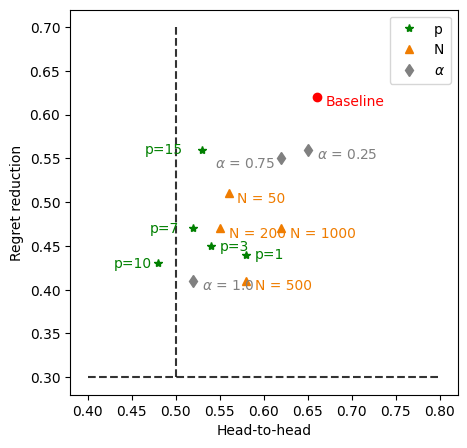

In [63]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))
p_indices = [0,1,3,4,5]
plt.plot(h2h_p[p_indices], regret_p[p_indices], color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[p_indices[0]] + 0.01, regret_p[p_indices[0]] - 0.005, 'p='+str(num_feat_all[p_indices[0]]), color='green')
plt.text(h2h_p[p_indices[1]] + 0.01, regret_p[p_indices[1]] - 0.005, 'p='+str(num_feat_all[p_indices[1]]), color='green')
plt.text(h2h_p[p_indices[2]] - 0.05, regret_p[p_indices[2]] - 0.005, 'p='+str(num_feat_all[p_indices[2]]), color='green')
plt.text(h2h_p[p_indices[3]] - 0.05, regret_p[p_indices[3]] - 0.005, 'p='+str(num_feat_all[p_indices[3]]), color='green')
plt.text(h2h_p[p_indices[4]] - 0.065, regret_p[p_indices[4]] - 0.005, 'p='+str(num_feat_all[p_indices[4]]), color='green')

# plt.plot(h2h_d[0], regret_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# # plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d[2], regret_d[2], color='#003D7C', marker = "o", linestyle = 'None')
# plt.plot(h2h_d[3], regret_d[3], color='#003D7C', marker = "o", linestyle = 'None')
# plt.text(h2h_d[0] + 0.01, regret_d[0] - 0.005, 'd = 5', color='#003D7C')
# # plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
# plt.text(h2h_d[2] + 0.01, regret_d[2] - 0.005, 'd = 25', color='#003D7C')
# plt.text(h2h_d[3] - 0.065, regret_d[3] - 0.005, 'd = 50', color='#003D7C')


plt.plot(h2h_N[0], regret_N[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
plt.text(h2h_N[1] + 0.01, regret_N[1] - 0.01, 'Baseline', color='red')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[2], regret_N[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[3], regret_N[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[4], regret_N[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N[0] + 0.01, regret_N[0] - 0.01, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N[2] + 0.01, regret_N[2] - 0.01, 'N = 200', color='#EF7C00')
plt.text(h2h_N[3] + 0.01, regret_N[3] - 0.01, 'N = 500', color='#EF7C00')
plt.text(h2h_N[4] + 0.01, regret_N[4] - 0.01, 'N = 1000', color='#EF7C00')


plt.plot(h2h_e[0], regret_e[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e[2], regret_e[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_e[3], regret_e[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_e[0] + 0.01, regret_e[0] - 0.01, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_e[2] - 0.075, regret_e[2] - 0.01, r'$\alpha$ = 0.75', color='grey')
plt.text(h2h_e[3] + 0.01, regret_e[3] - 0.01, r'$\alpha$ = 1.0', color='grey')

plt.vlines(0.5, 0.3, 0.7, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.3, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N[1], regret_N[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath_parent+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(DataPath_parent+'DDR_vs_OLS_diff_settings.pdf', format='pdf', bbox_inches="tight")
plt.show()

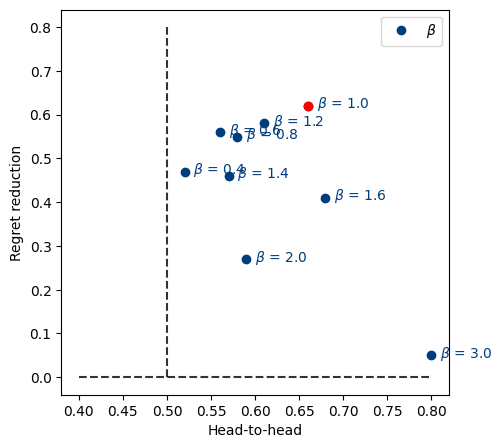

In [64]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5, 5))

plt.plot(h2h_deg, regret_deg, color='#003D7C', marker = "o", label = r'$\beta$', linestyle = 'None')

for deg_index in range(len(deg_all)):
    deg = deg_all[deg_index]
    plt.text(h2h_deg[deg_index] + 0.01, regret_deg[deg_index] - 0.005, r'$\beta$ = '+str(deg), color='#003D7C')

plt.vlines(0.5, 0.0, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.0, 0.4, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_N[1], regret_N[1], color='red', marker = "o", linestyle = 'None')
# plt.annotate('Ridge vs. DDR', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

# fig.savefig(DataPath+'DDR_vs_OLS_DPSN.eps', format='eps', bbox_inches="tight")
fig.savefig(DataPath_parent+'DDR_vs_OLS_Model_Mis.pdf', format='pdf', bbox_inches="tight")
plt.show()